In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import pandas as pd
import numpy as np
import random
import pickle
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import seaborn as sns
# from ucimlrepo import fetch_ucirepo 

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split

from data.data_loader import PowerConsumptionDataset, PowerWeatherDataset
from models.lstm import LSTMModel
from models.lstm_attention import LSTMWithAttention, BiLSTMWithAttention
from models.gru import GRUModel
from models.utils import create_model, train_and_evaluate, load_model, evaluate_r2_score
from explainers.lime import LimeExplainer
from explainers.shap import ShapExplainer
from explainers.attention import AttentionExplainer
from explainers.grad_cam import GradCAMExplainer
from explainers.lrp import LRPExplainer

In [2]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [3]:
"""
시간 관련 데이터(Month, Day, Hour 등)를 함께 학습시키는 것은 out of memory 문제 때문에 추후 진행이 필요할 것 같습니다. 
즉, 시간 관련 데이터는 변환이 필요한데, .one-hot encoding이나 sin/cos 변환 시에는 feature 개수가 늘어서 momery 문제 발생 
embedding을 활용할 경우, 코드 변경이 많이 필요합니다. 추후 embedding 활용하는 쪽으로 해야될것 같습니다.


학습 데이터 크기로인한 OOM 문제 
1년 -> sequence_length = (24*365)*feature 개수(7) = 8760 * 7 = 61320
3개월 -> sequence_length = (24*90)*feature 개수(7) = 2160 * 7 = 15120
1개월 -> sequence_length = (24*30)*feature 개수(7) = 720 * 7 = 5040

"""

'\n시간 관련 데이터(Month, Day, Hour 등)를 함께 학습시키는 것은 out of memory 문제 때문에 추후 진행이 필요할 것 같습니다. \n즉, 시간 관련 데이터는 변환이 필요한데, .one-hot encoding이나 sin/cos 변환 시에는 feature 개수가 늘어서 momery 문제 발생 \nembedding을 활용할 경우, 코드 변경이 많이 필요합니다. 추후 embedding 활용하는 쪽으로 해야될것 같습니다.\n\n\n학습 데이터 크기로인한 OOM 문제 \n1년 -> sequence_length = (24*365)*feature 개수(7) = 8760 * 7 = 61320\n3개월 -> sequence_length = (24*90)*feature 개수(7) = 2160 * 7 = 15120\n1개월 -> sequence_length = (24*30)*feature 개수(7) = 720 * 7 = 5040\n\n'

In [5]:
"""
feature 종류
- datetime: sin/cos 인코딩 진행 -> 각 월/일/시를 sin_month, cos_month 형태로 데이터에 포함시킴
- Global_active_power
- Global_intensity
- Sub_metering_1, Sub_metering_2, Sub_metering_3
- Temp_Avg, Munidity_Avg
- sin_hour, cos_hour
- sin_day, cos_day
- sin_month, cos_month
"""

# target_features = ['Global_active_power', 'Global_intensity', 
#                    'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 
#                    'Temp_Avg', 'Humidity_Avg', 'sin_hour', 'cos_hour', 
#                    'sin_day', 'cos_day', 'sin_month', 'cos_month']
# file_path = 'data/final_hourly_power_weather_avg_with_time.csv'


target_features = ['Global_active_power', 'Global_intensity', 
                   'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3'] #, 
          #         'Temp_Avg', 'Humidity_Avg']
file_path = 'data/final_hourly_power_weather_avg.csv'


target_features = ['Global_active_power', 'Global_active_power', 'Voltage', 'Global_intensity', 
                   'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
file_path = 'data/hourly_household_power_consumption.csv'

sequence_length = 24*30 # (24시간 x 일수)
prediction_length = 24

dataset = PowerWeatherDataset(file_path=file_path, 
                              sequence_length=sequence_length, prediction_length=prediction_length, 
                              target_features = target_features)
train_sequences, eval_sequences, train_targets, eval_targets = dataset.load_data()

print('train_sequences shape: ', train_sequences.shape)
print('train_targets shape: ', train_targets.shape)
print('eval_sequences shape: ', eval_sequences.shape)
print('eval_targets shape: ', eval_targets.shape)

/archive/workspace/XAI/co-work/data/data_loader.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)  # Use forward fill or interpolation for time series data


train_sequences shape:  (26927, 720, 7)
train_targets shape:  (26927, 24)
eval_sequences shape:  (6174, 720, 7)
eval_targets shape:  (6174, 24)


In [6]:
# 'LSTM' or 'GRU' for LIME and SHAP, 'LSTM_Attention' for 'Attention' 
model_name = 'LSTM'  
input_size = len(dataset.selected_features)  # Number of features
hidden_size = 64
num_layers = 2  
output_size = 24  
num_epochs = 200
dropout = 0.3
batch_size = 64
learning_rate = 0.001
patience = 15
num_of_features = input_size

# 모델 저장 시, feature 개수(ft_num), 일수(days) 넣음
model_path = './trained_models/{}_ftnum_{}_days_{}.pth'.format(model_name, 
                                                              num_of_features,
                                                              int(sequence_length/24))
# lime_path = './trained_explainer/lime_explainer_config.json'

print('model_path: ', model_path)

model_path:  ./trained_models/LSTM_ftnum_7_days_30.pth


In [7]:
model = create_model(model_name, input_size, hidden_size, num_layers, output_size, dropout)

# Check if the model already exists
if os.path.exists(model_path):
    print(f"Loading the pre-trained {model_name} model...")
    model = load_model(model, model_path)
    # model = nn.DataParallel(model)
    model.to(device)
else:
    print(f"Training a new {model_name} model...")
    train_and_evaluate(model, model_name, train_sequences, train_targets, 
                       eval_sequences, eval_targets, model_path,
                       num_epochs, batch_size, learning_rate, patience)

Training a new LSTM model...


Epoch 1/200: 100%|███████████████████████████████████| 421/421 [00:02<00:00, 170.06batch/s, loss=0.0157]


Epoch [1/200], Train Loss: 0.0186, Val Loss: 0.0091
Validation loss improved. Model saved at epoch 1


Epoch 2/200: 100%|███████████████████████████████████| 421/421 [00:02<00:00, 179.89batch/s, loss=0.0151]


Epoch [2/200], Train Loss: 0.0136, Val Loss: 0.0091
Validation loss improved. Model saved at epoch 2


Epoch 3/200: 100%|███████████████████████████████████| 421/421 [00:02<00:00, 179.25batch/s, loss=0.0117]


Epoch [3/200], Train Loss: 0.0128, Val Loss: 0.0085
Validation loss improved. Model saved at epoch 3


Epoch 4/200: 100%|███████████████████████████████████| 421/421 [00:02<00:00, 178.53batch/s, loss=0.0107]


Epoch [4/200], Train Loss: 0.0126, Val Loss: 0.0084
Validation loss improved. Model saved at epoch 4


Epoch 5/200: 100%|███████████████████████████████████| 421/421 [00:02<00:00, 177.05batch/s, loss=0.0107]


Epoch [5/200], Train Loss: 0.0123, Val Loss: 0.0083
Validation loss improved. Model saved at epoch 5


Epoch 6/200: 100%|████████████████████████████████████| 421/421 [00:02<00:00, 177.96batch/s, loss=0.013]


Epoch [6/200], Train Loss: 0.0122, Val Loss: 0.0085


Epoch 7/200: 100%|███████████████████████████████████| 421/421 [00:02<00:00, 178.13batch/s, loss=0.0124]


Epoch [7/200], Train Loss: 0.0121, Val Loss: 0.0084


Epoch 8/200: 100%|██████████████████████████████████| 421/421 [00:02<00:00, 177.93batch/s, loss=0.00964]


Epoch [8/200], Train Loss: 0.0120, Val Loss: 0.0082
Validation loss improved. Model saved at epoch 8


Epoch 9/200: 100%|███████████████████████████████████| 421/421 [00:02<00:00, 178.38batch/s, loss=0.0124]


Epoch [9/200], Train Loss: 0.0119, Val Loss: 0.0081
Validation loss improved. Model saved at epoch 9


Epoch 10/200: 100%|██████████████████████████████████| 421/421 [00:02<00:00, 177.81batch/s, loss=0.0144]


Epoch [10/200], Train Loss: 0.0118, Val Loss: 0.0091


Epoch 11/200: 100%|██████████████████████████████████| 421/421 [00:02<00:00, 177.91batch/s, loss=0.0134]


Epoch [11/200], Train Loss: 0.0117, Val Loss: 0.0084


Epoch 12/200: 100%|██████████████████████████████████| 421/421 [00:02<00:00, 176.70batch/s, loss=0.0113]


Epoch [12/200], Train Loss: 0.0116, Val Loss: 0.0083


Epoch 13/200: 100%|██████████████████████████████████| 421/421 [00:02<00:00, 176.53batch/s, loss=0.0115]


Epoch [13/200], Train Loss: 0.0115, Val Loss: 0.0085


Epoch 14/200: 100%|███████████████████████████████████| 421/421 [00:02<00:00, 177.35batch/s, loss=0.013]


Epoch [14/200], Train Loss: 0.0114, Val Loss: 0.0086


Epoch 15/200: 100%|██████████████████████████████████| 421/421 [00:02<00:00, 176.69batch/s, loss=0.0117]


Epoch [15/200], Train Loss: 0.0112, Val Loss: 0.0090


Epoch 16/200: 100%|██████████████████████████████████| 421/421 [00:02<00:00, 176.77batch/s, loss=0.0121]


Epoch [16/200], Train Loss: 0.0111, Val Loss: 0.0088


Epoch 17/200: 100%|██████████████████████████████████| 421/421 [00:02<00:00, 175.99batch/s, loss=0.0109]


Epoch [17/200], Train Loss: 0.0109, Val Loss: 0.0088


Epoch 18/200: 100%|██████████████████████████████████| 421/421 [00:02<00:00, 176.07batch/s, loss=0.0122]


Epoch [18/200], Train Loss: 0.0106, Val Loss: 0.0087


Epoch 19/200: 100%|██████████████████████████████████| 421/421 [00:02<00:00, 175.78batch/s, loss=0.0128]


Epoch [19/200], Train Loss: 0.0105, Val Loss: 0.0093


Epoch 20/200: 100%|█████████████████████████████████| 421/421 [00:02<00:00, 175.37batch/s, loss=0.00868]


Epoch [20/200], Train Loss: 0.0103, Val Loss: 0.0091


Epoch 21/200: 100%|█████████████████████████████████| 421/421 [00:02<00:00, 176.18batch/s, loss=0.00883]


Epoch [21/200], Train Loss: 0.0101, Val Loss: 0.0092


Epoch 22/200: 100%|██████████████████████████████████| 421/421 [00:02<00:00, 175.90batch/s, loss=0.0107]


Epoch [22/200], Train Loss: 0.0099, Val Loss: 0.0092


Epoch 23/200: 100%|█████████████████████████████████| 421/421 [00:02<00:00, 175.28batch/s, loss=0.00827]


Epoch [23/200], Train Loss: 0.0098, Val Loss: 0.0093


Epoch 24/200: 100%|██████████████████████████████████| 421/421 [00:02<00:00, 175.89batch/s, loss=0.0119]


Epoch [24/200], Train Loss: 0.0098, Val Loss: 0.0096
Early stopping applied at epoch 24


In [8]:
r2 = evaluate_r2_score(model, eval_sequences, eval_targets, model_name)

R² Score: 0.2207


In [11]:
input_size = len(dataset.selected_features)  # Number of features
hidden_size = 256
num_layers = 3  
output_size = 24  
num_epochs = 300
dropout = 0.1
batch_size = 64
learning_rate = 0.0005
patience = 15
num_of_features = input_size

model_name_attention = 'LSTM_Attention'  
model_attention_path = './trained_models/{}_ftnum_{}_days_{}.pth'.format(model_name_attention, 
                                                              num_of_features,
                                                              int(sequence_length/24))                      
print(model_attention_path)

./trained_models/LSTM_Attention_ftnum_7_days_30.pth


In [12]:
model_attention = create_model(model_name_attention, input_size, hidden_size, num_layers, output_size, dropout)

# Check if the model already exists
if os.path.exists(model_attention_path):
    print(f"Loading the pre-trained {model_name_attention} model...")
    model_attention = load_model(model_attention, model_attention_path)
    model_attention.to(device)
else:
    print(f"Training a new {model_name_attention} model...")
    train_and_evaluate(model_attention, model_name_attention, train_sequences, train_targets, 
                   eval_sequences, eval_targets, model_attention_path,
                   num_epochs=300, batch_size=64, learning_rate=learning_rate, patience=patience)

Training a new LSTM_Attention model...


Epoch 1/300: 100%|████████████████████████████████████| 421/421 [01:06<00:00,  6.31batch/s, loss=0.0191]


Epoch [1/300], Train Loss: 0.0192, Val Loss: 0.0116
Validation loss improved. Model saved at epoch 1


Epoch 2/300: 100%|████████████████████████████████████| 421/421 [01:06<00:00,  6.30batch/s, loss=0.0178]


Epoch [2/300], Train Loss: 0.0183, Val Loss: 0.0116
Validation loss improved. Model saved at epoch 2


Epoch 3/300: 100%|█████████████████████████████████████| 421/421 [01:06<00:00,  6.29batch/s, loss=0.019]


Epoch [3/300], Train Loss: 0.0182, Val Loss: 0.0118


Epoch 4/300: 100%|████████████████████████████████████| 421/421 [01:07<00:00,  6.28batch/s, loss=0.0206]


Epoch [4/300], Train Loss: 0.0180, Val Loss: 0.0116


Epoch 5/300: 100%|████████████████████████████████████| 421/421 [01:06<00:00,  6.29batch/s, loss=0.0189]


Epoch [5/300], Train Loss: 0.0180, Val Loss: 0.0115
Validation loss improved. Model saved at epoch 5


Epoch 6/300: 100%|████████████████████████████████████| 421/421 [01:06<00:00,  6.29batch/s, loss=0.0159]


Epoch [6/300], Train Loss: 0.0179, Val Loss: 0.0115


Epoch 7/300: 100%|████████████████████████████████████| 421/421 [01:06<00:00,  6.29batch/s, loss=0.0191]


Epoch [7/300], Train Loss: 0.0178, Val Loss: 0.0121


Epoch 8/300: 100%|████████████████████████████████████| 421/421 [01:07<00:00,  6.27batch/s, loss=0.0169]


Epoch [8/300], Train Loss: 0.0177, Val Loss: 0.0118


Epoch 9/300: 100%|████████████████████████████████████| 421/421 [01:06<00:00,  6.28batch/s, loss=0.0146]


Epoch [9/300], Train Loss: 0.0176, Val Loss: 0.0115


Epoch 10/300: 100%|███████████████████████████████████| 421/421 [01:07<00:00,  6.27batch/s, loss=0.0179]


Epoch [10/300], Train Loss: 0.0176, Val Loss: 0.0115
Validation loss improved. Model saved at epoch 10


Epoch 11/300: 100%|███████████████████████████████████| 421/421 [01:07<00:00,  6.28batch/s, loss=0.0188]


Epoch [11/300], Train Loss: 0.0175, Val Loss: 0.0118


Epoch 12/300: 100%|███████████████████████████████████| 421/421 [01:07<00:00,  6.27batch/s, loss=0.0175]


Epoch [12/300], Train Loss: 0.0175, Val Loss: 0.0123


Epoch 13/300: 100%|███████████████████████████████████| 421/421 [01:07<00:00,  6.27batch/s, loss=0.0183]


Epoch [13/300], Train Loss: 0.0174, Val Loss: 0.0121


Epoch 14/300: 100%|███████████████████████████████████| 421/421 [01:07<00:00,  6.27batch/s, loss=0.0176]


Epoch [14/300], Train Loss: 0.0174, Val Loss: 0.0123


Epoch 15/300: 100%|███████████████████████████████████| 421/421 [01:07<00:00,  6.28batch/s, loss=0.0181]


Epoch [15/300], Train Loss: 0.0173, Val Loss: 0.0121


Epoch 16/300: 100%|███████████████████████████████████| 421/421 [01:06<00:00,  6.28batch/s, loss=0.0153]


Epoch [16/300], Train Loss: 0.0173, Val Loss: 0.0130


Epoch 17/300: 100%|███████████████████████████████████| 421/421 [01:07<00:00,  6.27batch/s, loss=0.0199]


Epoch [17/300], Train Loss: 0.0173, Val Loss: 0.0122


Epoch 18/300: 100%|████████████████████████████████████| 421/421 [01:07<00:00,  6.28batch/s, loss=0.014]


Epoch [18/300], Train Loss: 0.0172, Val Loss: 0.0122


Epoch 19/300: 100%|███████████████████████████████████| 421/421 [01:07<00:00,  6.27batch/s, loss=0.0177]


Epoch [19/300], Train Loss: 0.0172, Val Loss: 0.0122


Epoch 20/300: 100%|███████████████████████████████████| 421/421 [01:07<00:00,  6.27batch/s, loss=0.0194]


Epoch [20/300], Train Loss: 0.0172, Val Loss: 0.0121


Epoch 21/300: 100%|███████████████████████████████████| 421/421 [01:06<00:00,  6.29batch/s, loss=0.0159]


Epoch [21/300], Train Loss: 0.0172, Val Loss: 0.0128


Epoch 22/300: 100%|████████████████████████████████████| 421/421 [01:07<00:00,  6.28batch/s, loss=0.016]


Epoch [22/300], Train Loss: 0.0171, Val Loss: 0.0132


Epoch 23/300: 100%|███████████████████████████████████| 421/421 [01:07<00:00,  6.28batch/s, loss=0.0154]


Epoch [23/300], Train Loss: 0.0171, Val Loss: 0.0124


Epoch 24/300: 100%|███████████████████████████████████| 421/421 [01:07<00:00,  6.28batch/s, loss=0.0147]


Epoch [24/300], Train Loss: 0.0171, Val Loss: 0.0125


Epoch 25/300: 100%|███████████████████████████████████| 421/421 [01:06<00:00,  6.28batch/s, loss=0.0138]


Epoch [25/300], Train Loss: 0.0171, Val Loss: 0.0126
Early stopping applied at epoch 25


In [13]:
r2 = evaluate_r2_score(model_attention, eval_sequences, eval_targets, model_name_attention)

R² Score: -0.0240


## Explain

### LIME

In [8]:
explainer_type = 'LIME'  # or 'SHAP'

if explainer_type == 'LIME':
    explainer = LimeExplainer(model, device, eval_sequences, 
                              sequence_length=sequence_length, input_size=input_size, 
                              selected_features=dataset.selected_features, scaler=dataset.scaler)
elif explainer_type == 'SHAP':
    explainer = ShapExplainer(model, device, train_sequences, 
                              sequence_length=sequence_length, input_size=input_size, 
                              selected_features=dataset.selected_features)
else:
    raise ValueError(f"Explainer type '{explainer_type}' is not recognized.")

random_index:  1021


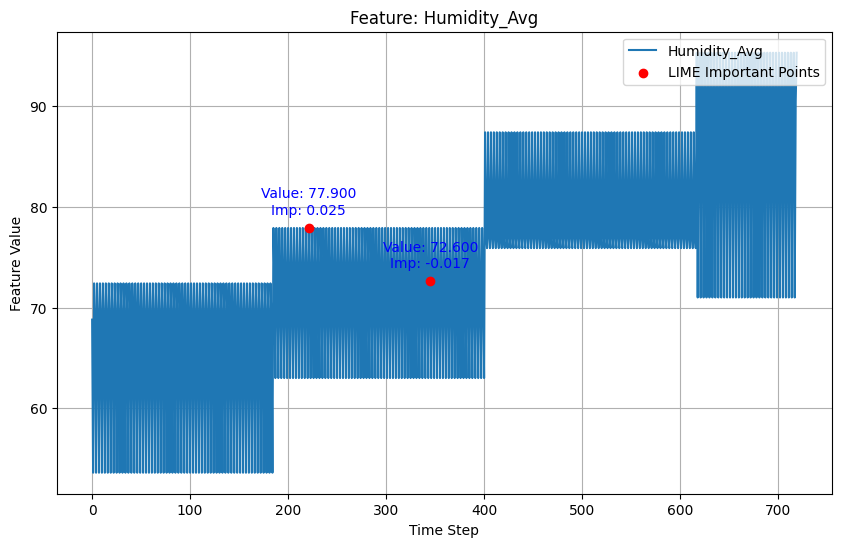


Feature: Humidity_Avg - Detailed Information
Time Step: 221, Feature Value: 77.900, Importance: 0.025
Time Step: 345, Feature Value: 72.600, Importance: -0.017


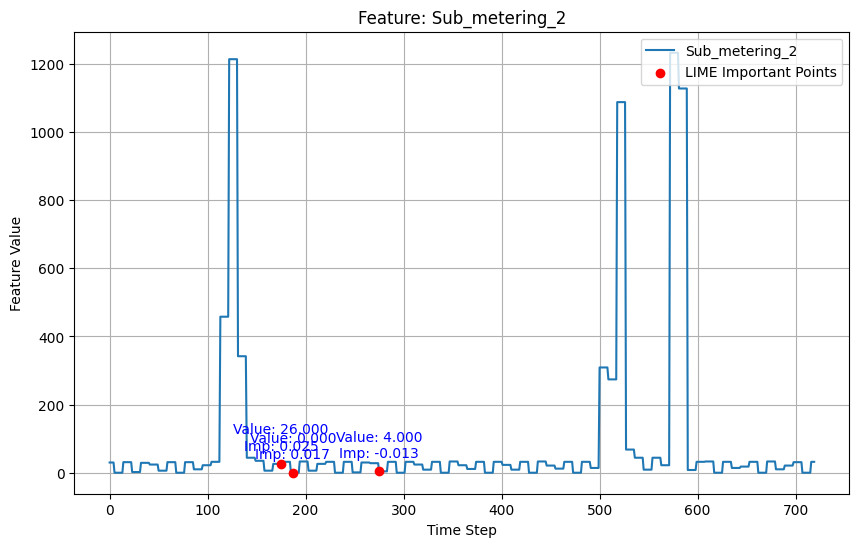


Feature: Sub_metering_2 - Detailed Information
Time Step: 175, Feature Value: 26.000, Importance: 0.025
Time Step: 187, Feature Value: 0.000, Importance: 0.017
Time Step: 275, Feature Value: 4.000, Importance: -0.013


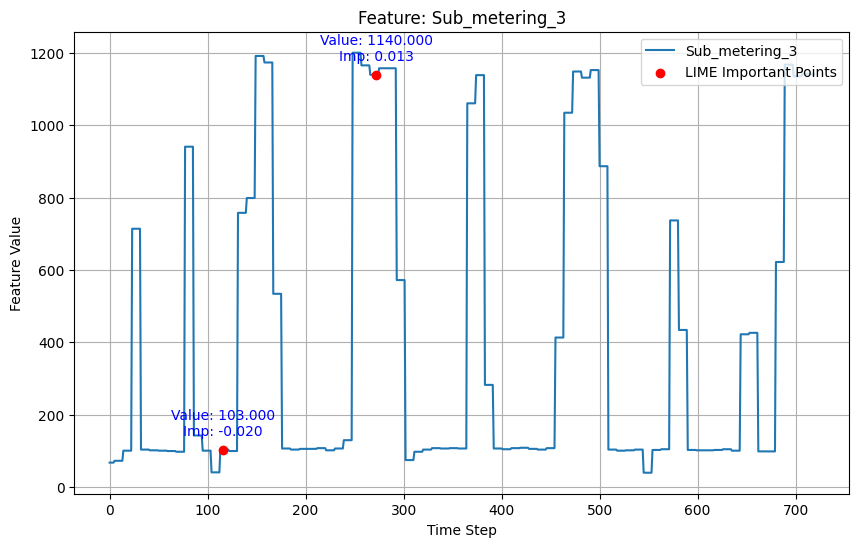


Feature: Sub_metering_3 - Detailed Information
Time Step: 116, Feature Value: 103.000, Importance: -0.020
Time Step: 272, Feature Value: 1140.000, Importance: 0.013


In [19]:
# Explain a specific data point
random_index = np.random.choice(len(eval_sequences)) 
random_data_point = eval_sequences[random_index] 
print('random_index: ', random_index)

explanation = explainer.explain(random_data_point, num_features=input_size)

### SHAP

타겟 출력 인덱스를 선택해야 하는 경우: Force, Waterfall, Dependence, Decision, Scatter, Partial Dependence Plot.
- 타겟 출력 인덱스를 정하고, 각 feature의 데이터포이터가 어떤 영향을 미치는지

모든 출력에 대해 평균을 내는 것이 적합한 경우: Summary, Bar, Beeswarm, Heatmap Plot.
- 모든 출력(24개)의 평균을 구하고, feature 별 영향도를 구함

In [9]:
explainer_type = 'SHAP' 

if explainer_type == 'LIME':
    explainer = LimeExplainer(model, device, eval_sequences, 
                              sequence_length=sequence_length, input_size=input_size, 
                              selected_features=dataset.selected_features)
elif explainer_type == 'SHAP':
    ## OOM 문제로 train_sequences smaple 개수 및 nsamples 줄임, batch를 활용하여 shap value 계산
    # device = torch.device('cpu')
    # model.to(device)
    explainer = ShapExplainer(model, train_sequences, sequence_length, 
                              input_size, dataset.selected_features, device)

else:
    raise ValueError(f"Explainer type '{explainer_type}' is not recognized.")

#### For one sample

In [9]:
torch.cuda.empty_cache()
num_samples = 1  
# shap_values, sampled_eval_sequences = explainer.explain(eval_sequences,
#                                                         num_samples=num_samples)
shap_values, sampled_eval_sequences = explainer.explain_DeepExplainer(eval_sequences, num_samples=num_samples)

/archive/library/anaconda3/envs/xai_311/lib/python3.11/site-packages/shap/explainers/_deep/deep_pytorch.py:243: UserWarning: unrecognized nn.Module: LSTM
  warnings.warn(f'unrecognized nn.Module: {module_type}')


Summary plot


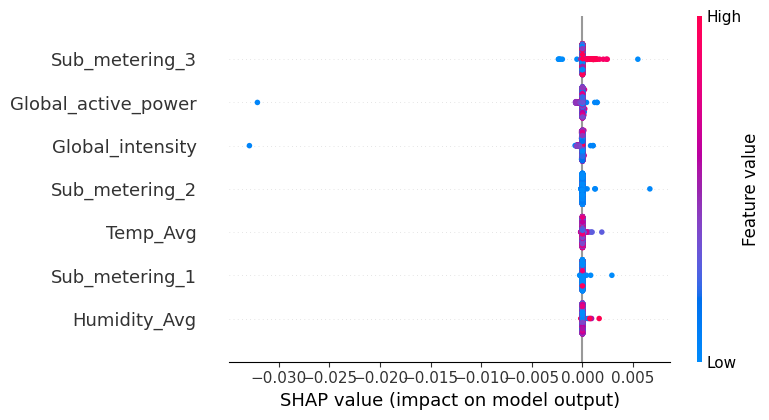

Force plot (target output index: 0)


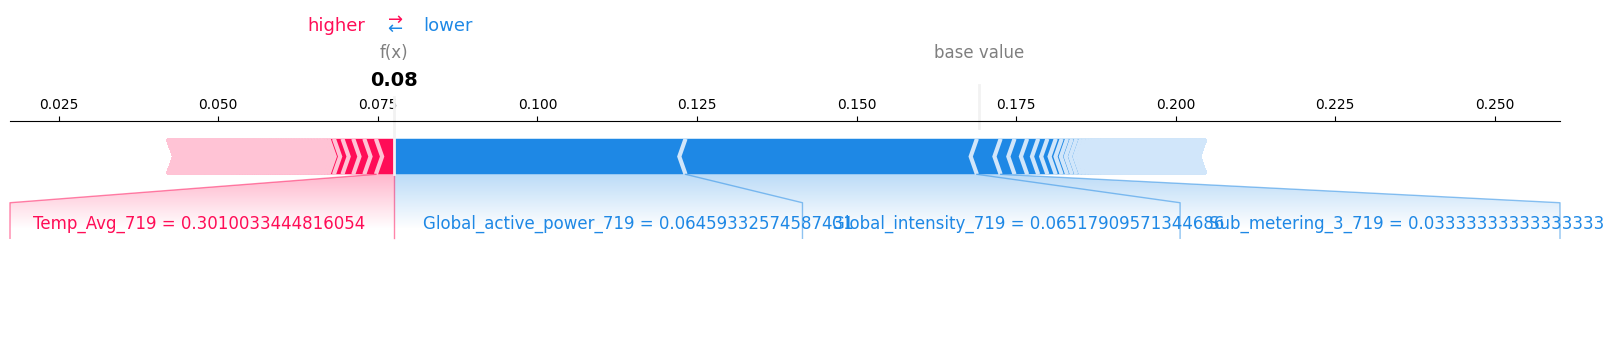

Waterfall plot (target output index: 0)


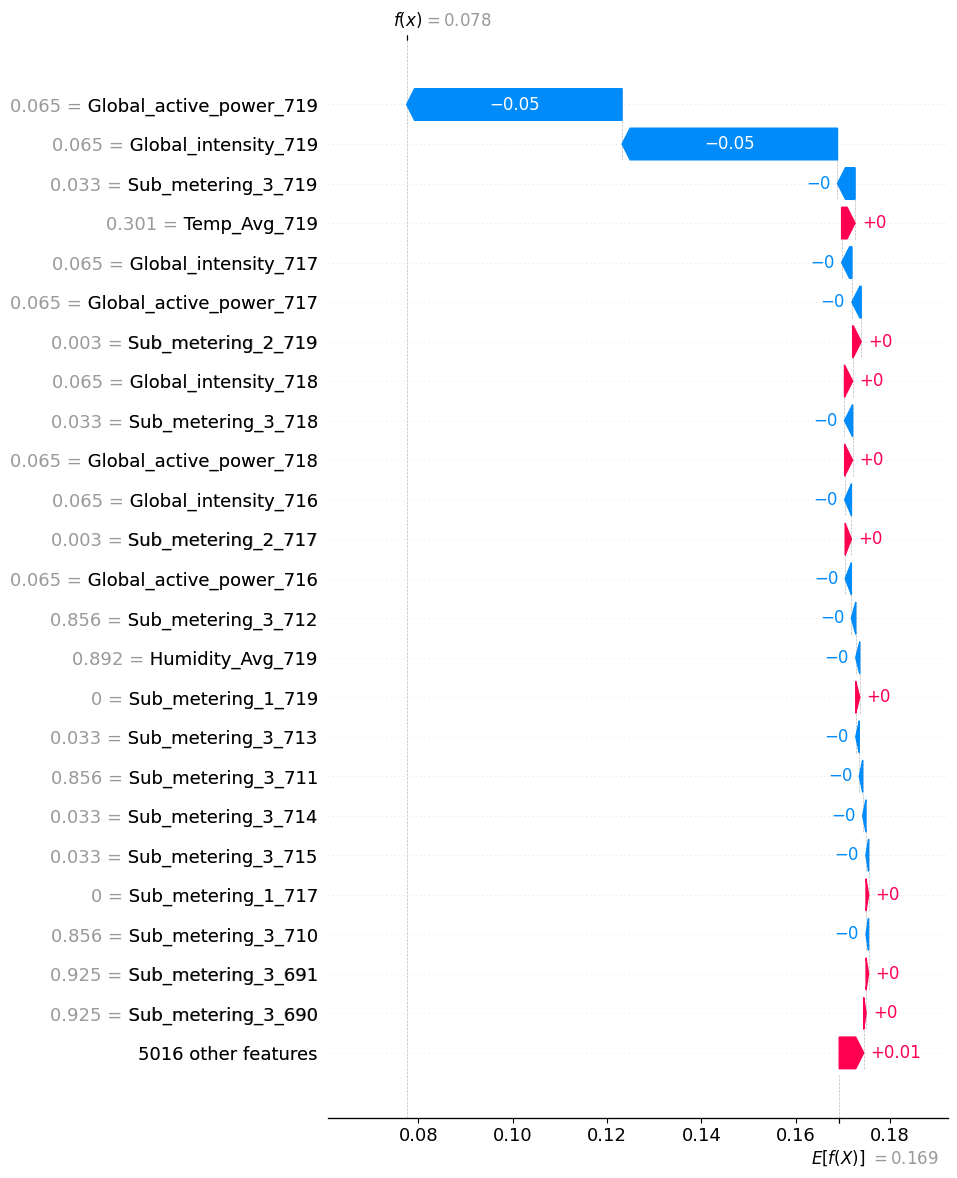

Dependence plot (target output index: 0)


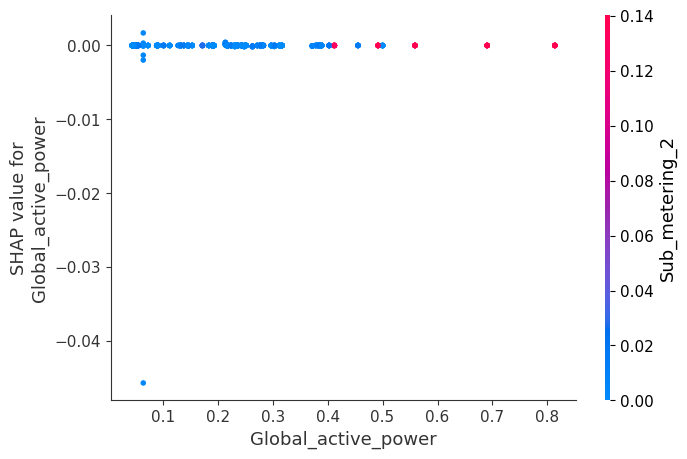

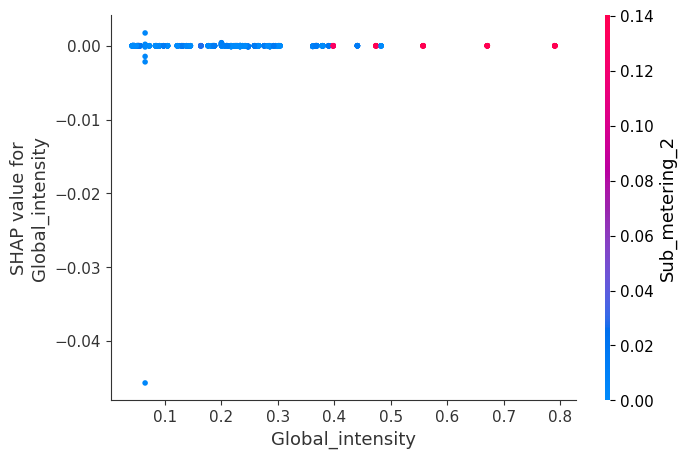

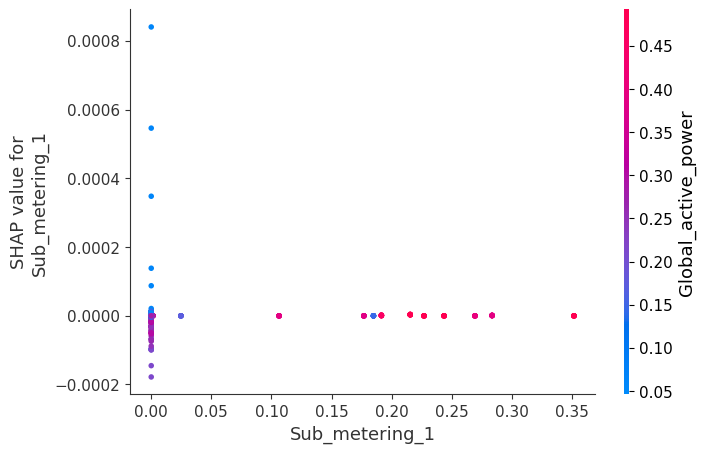

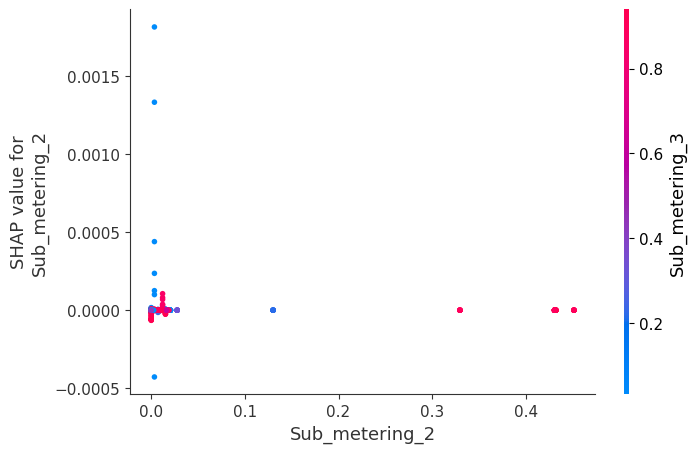

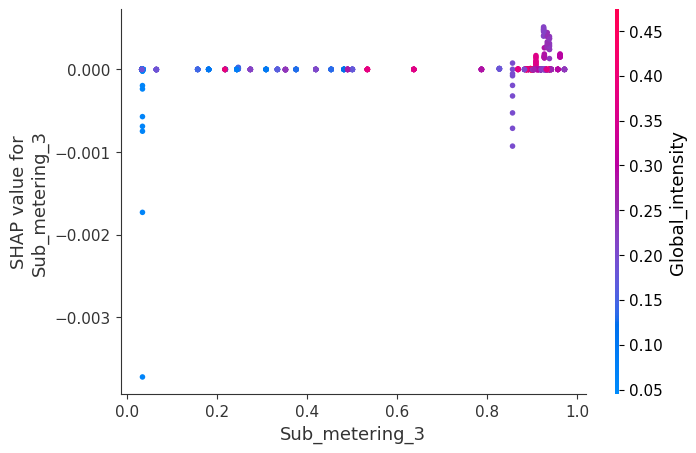

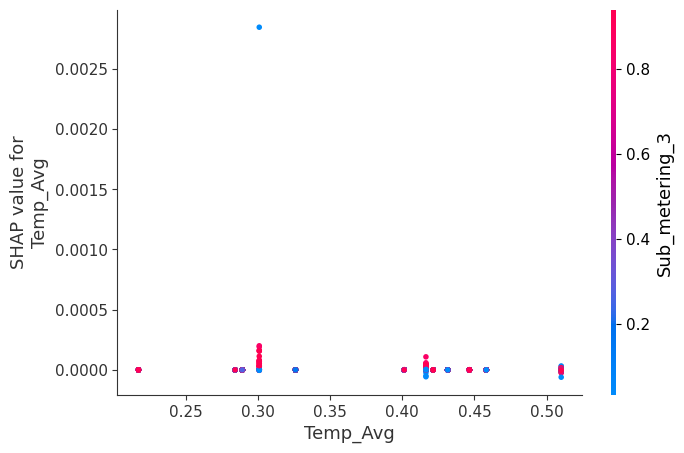

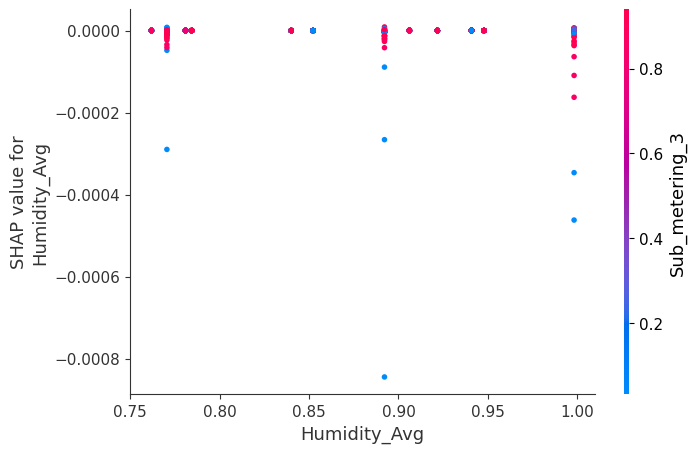

Decision plot (target output index: 0)


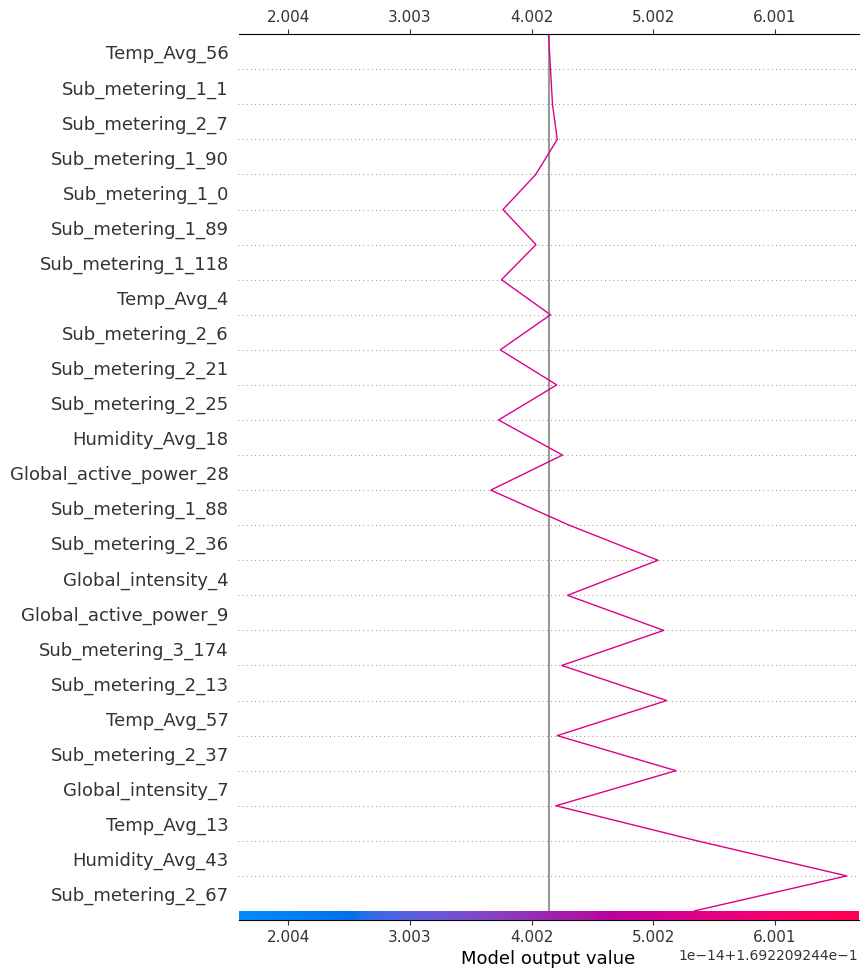

Scatter plot (target output index: 0)


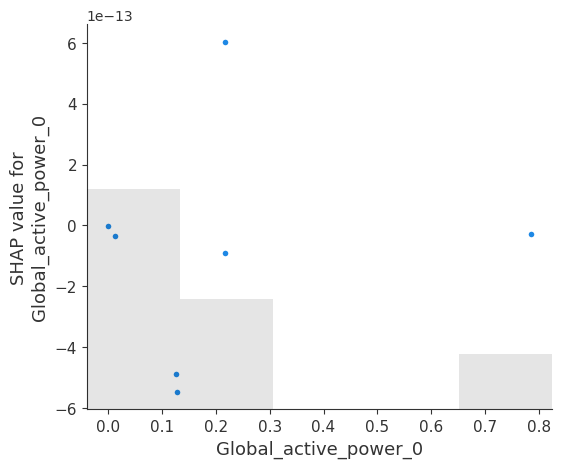

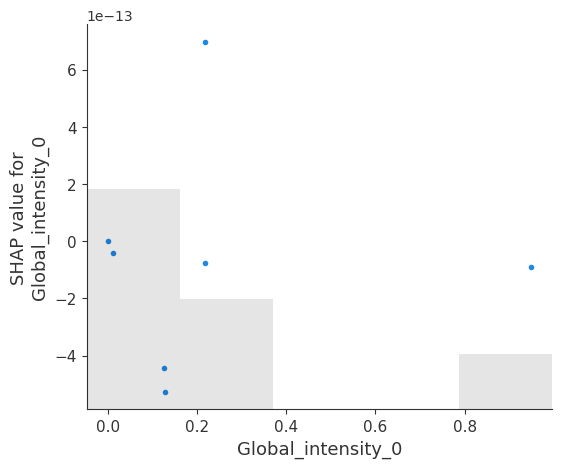

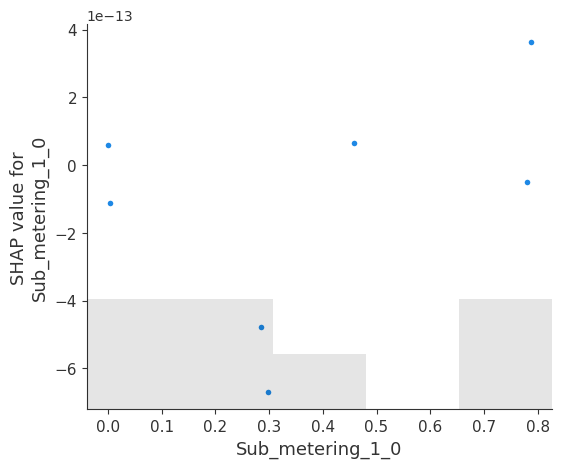

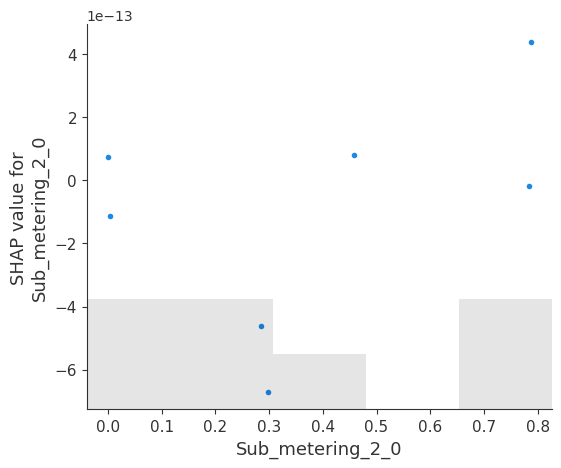

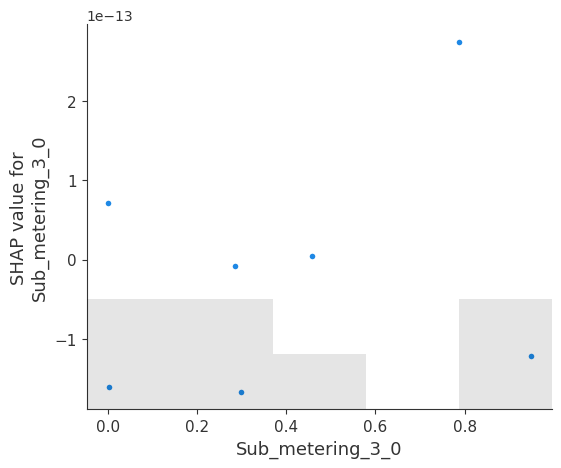

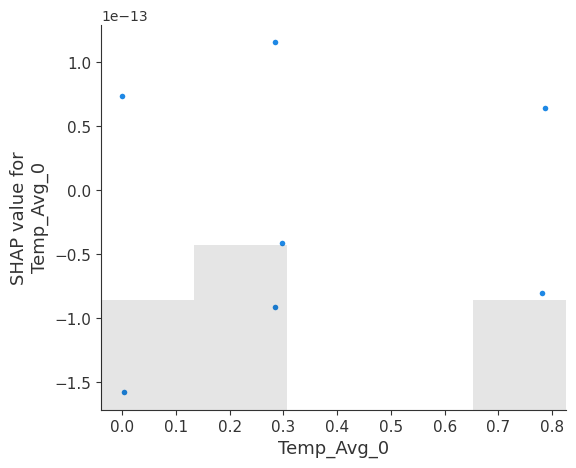

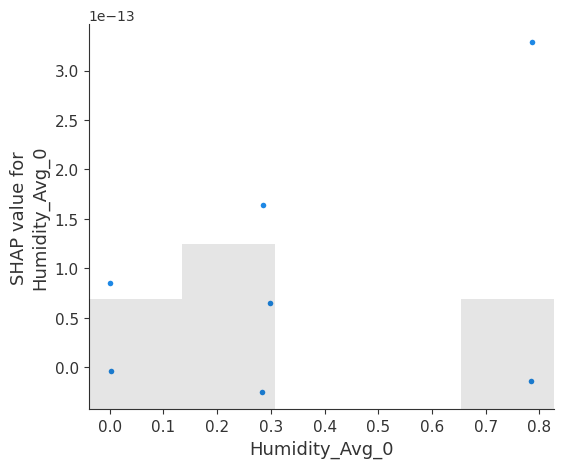

Bar plot


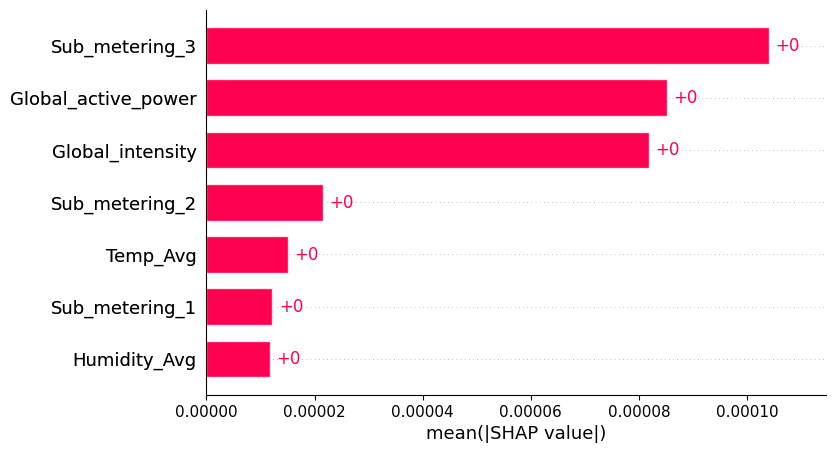

Beeswarm plot


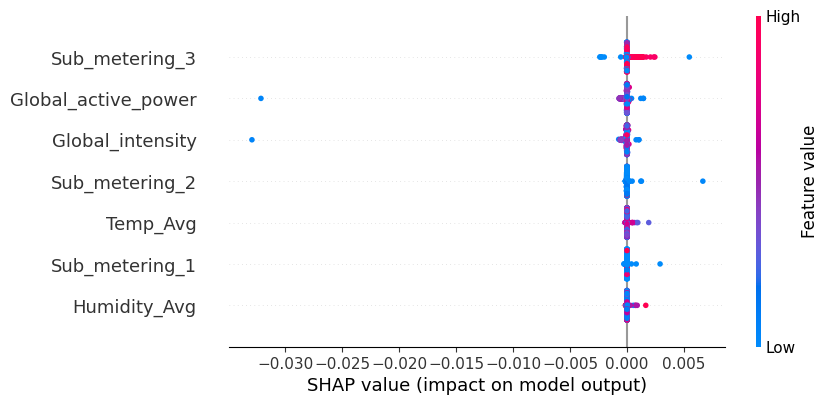

Heatmap plot


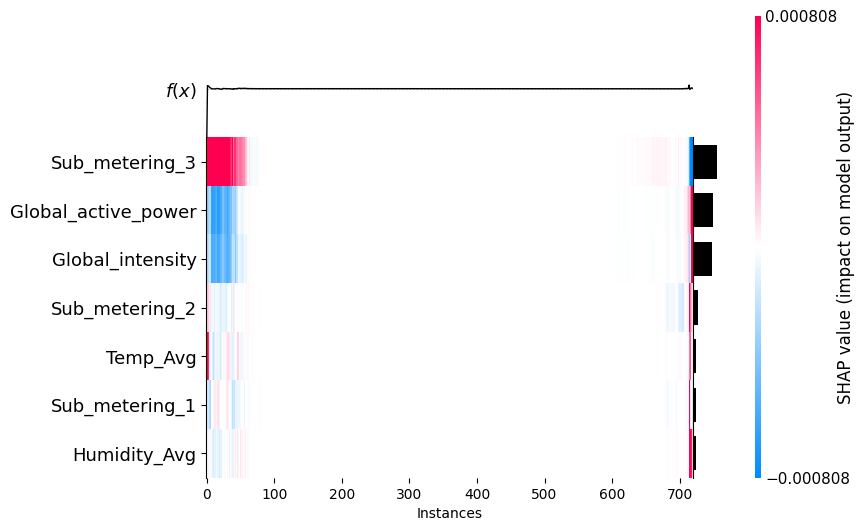

Partial Dependence Plot (feature: Global_active_power, target output index)


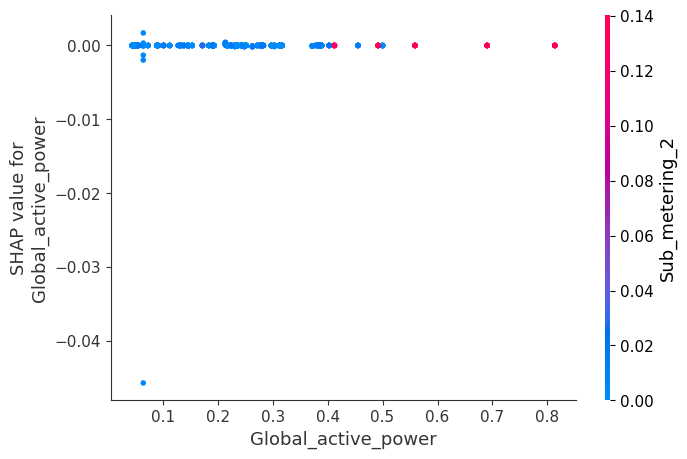

In [10]:
explainer.visualize_all_one_sample(shap_values[0], 
                                   sampled_eval_sequences[0], 
                                   target_f_idx1=0,
                                   target_f_idx2=1,
                                   target_idx=0)

#### For multiple samples

In [9]:
num_samples = 10  # 다수 샘플 사용
shap_values, sampled_eval_sequences = explainer.explain_DeepExplainer(eval_sequences, num_samples=num_samples)

/archive/library/anaconda3/envs/xai_311/lib/python3.11/site-packages/shap/explainers/_deep/deep_pytorch.py:243: UserWarning: unrecognized nn.Module: LSTM
  warnings.warn(f'unrecognized nn.Module: {module_type}')


@@:  (720, 7, 24)
Summary plot


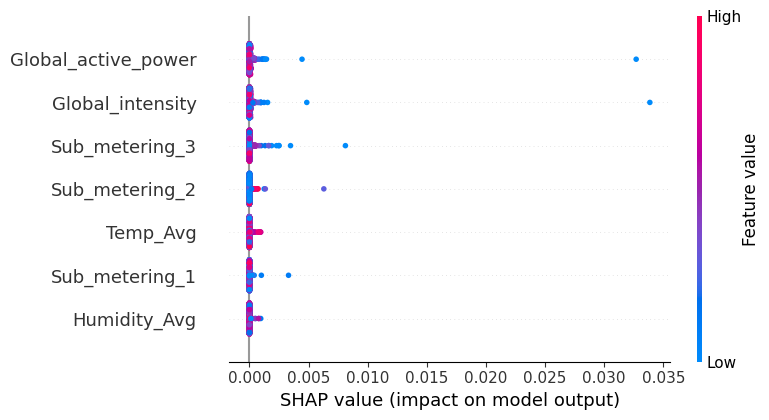

Force plot (target output index: 0)


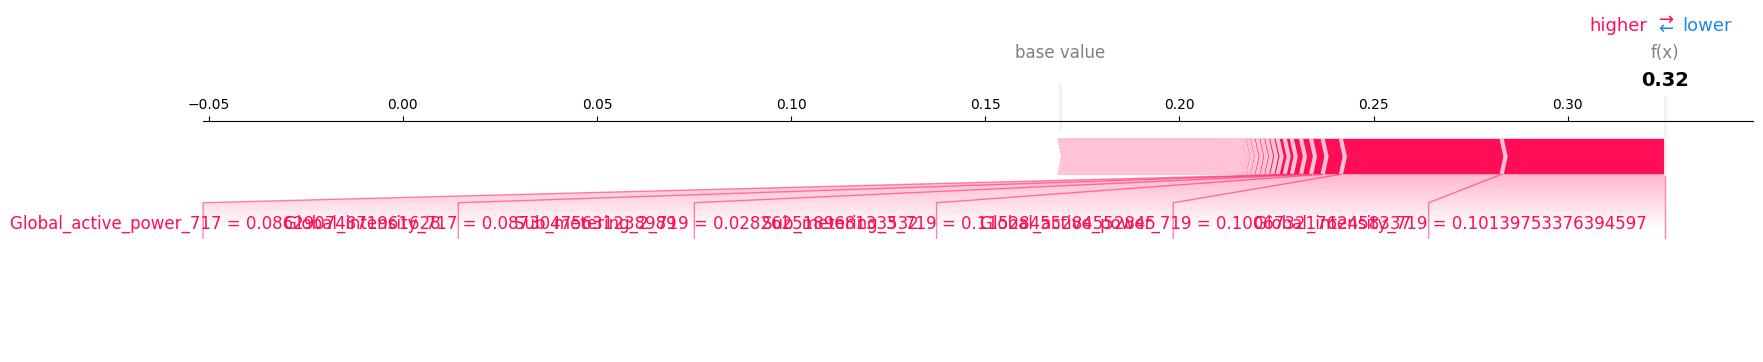

Waterfall plot (target output index: 0)


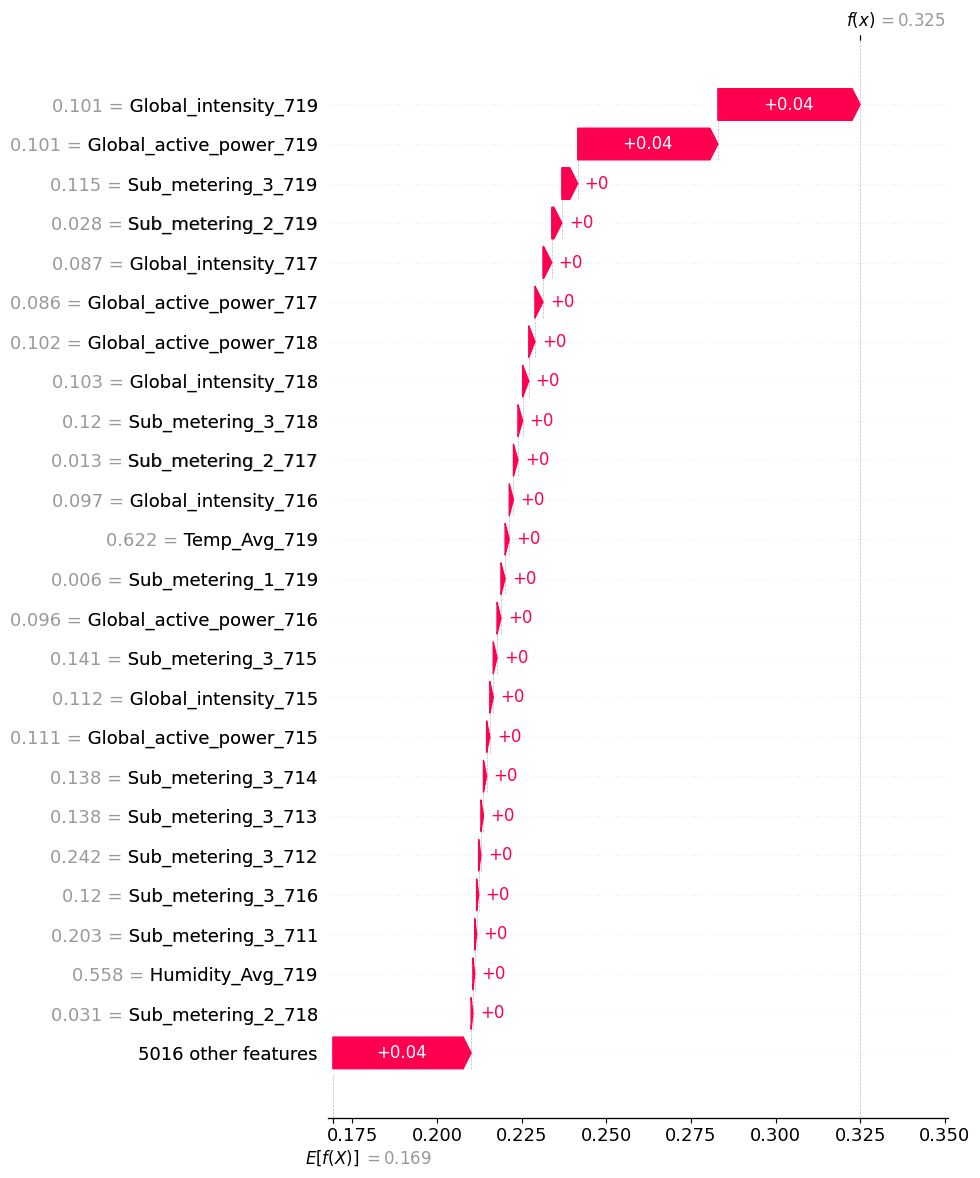

Dependence plot (target output index: 0)


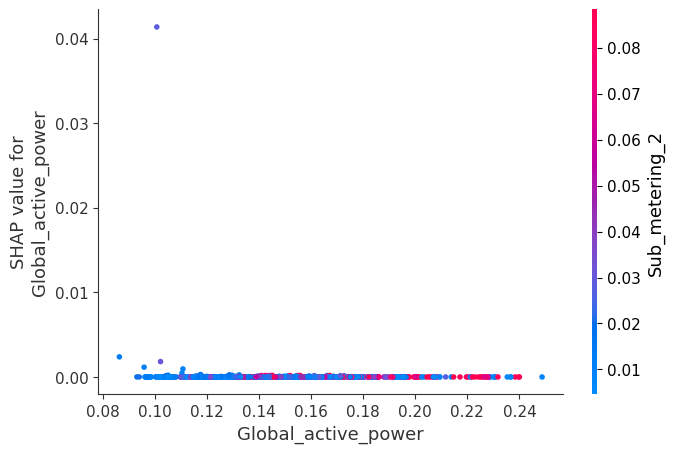

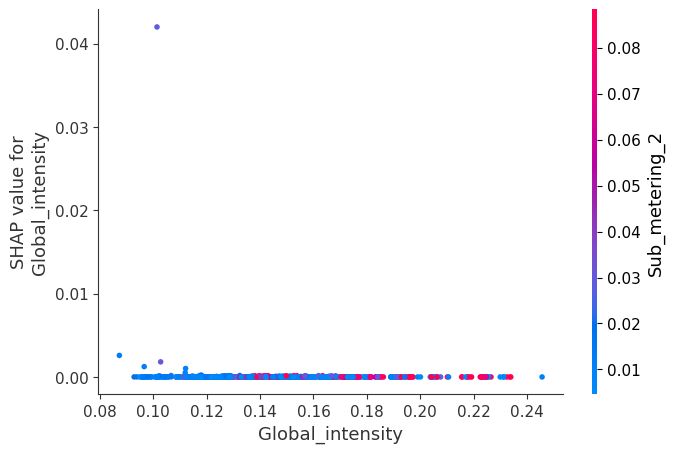

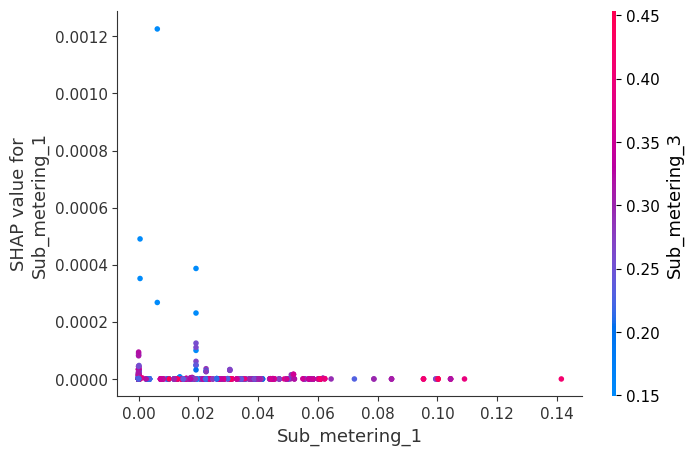

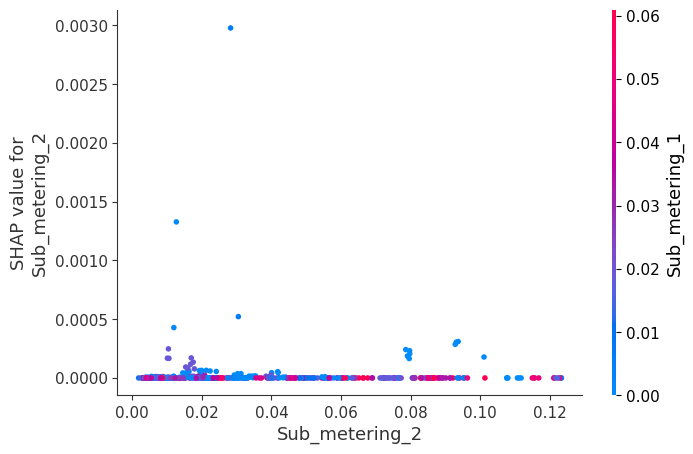

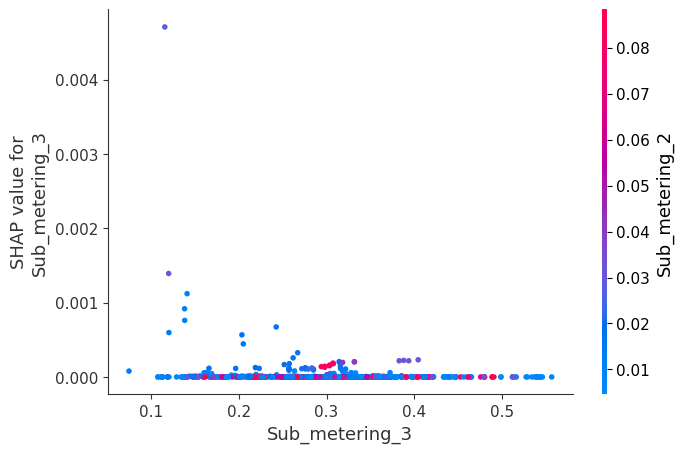

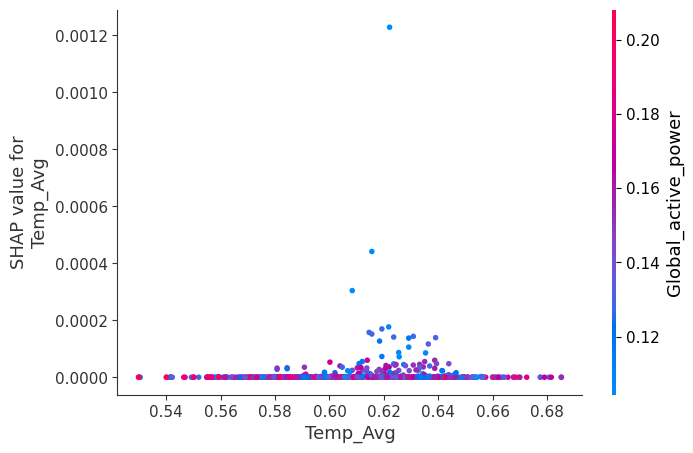

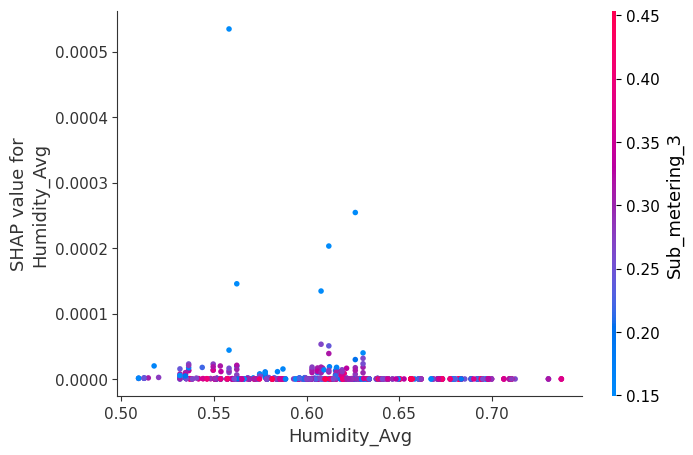

Decision plot (target output index: 0)


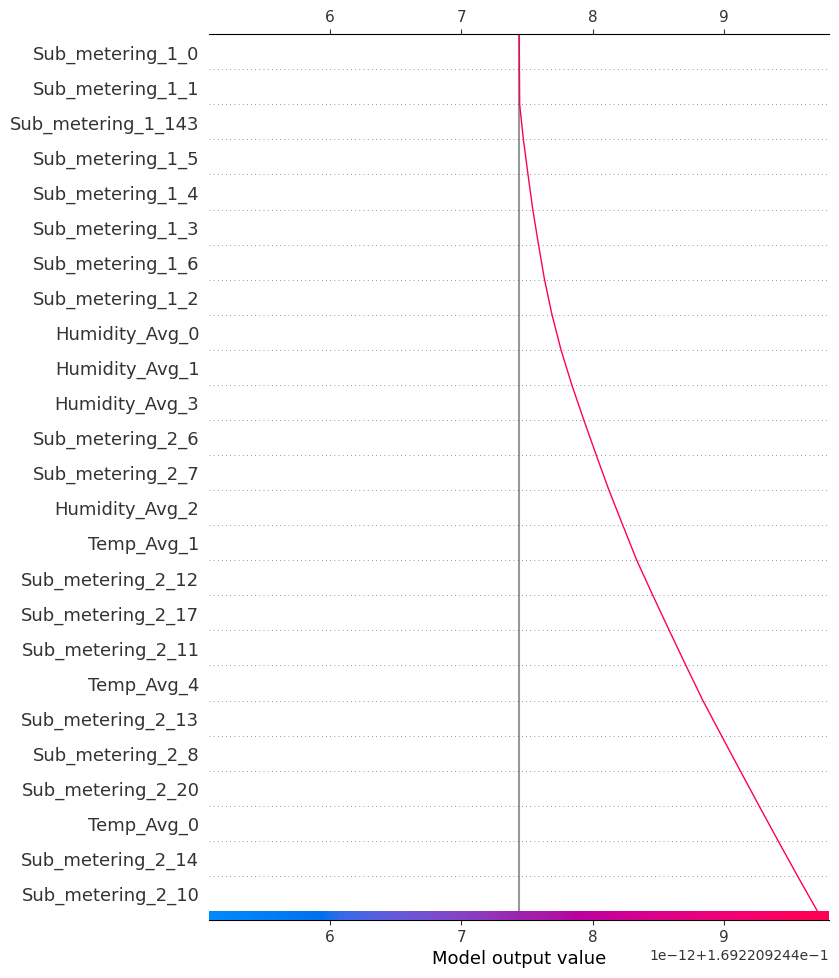

Scatter plot (target output index: 0)


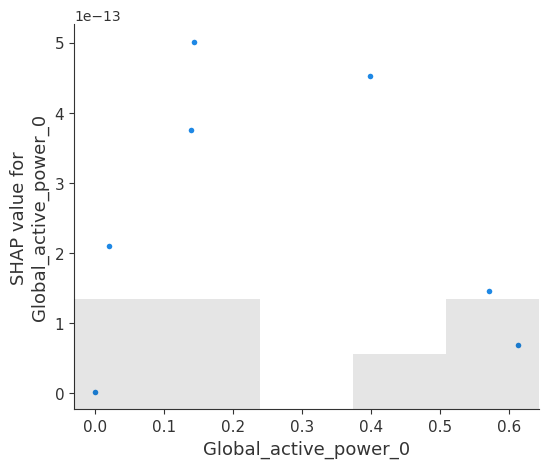

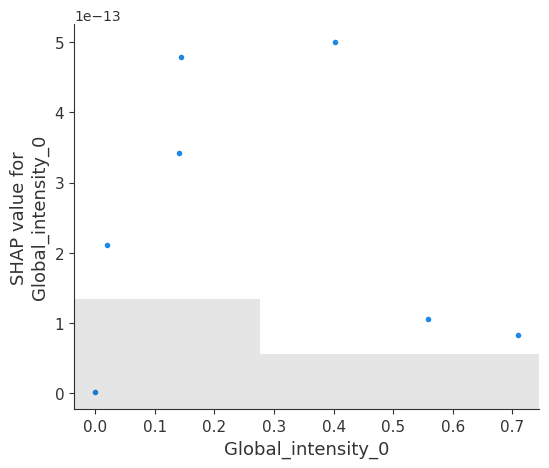

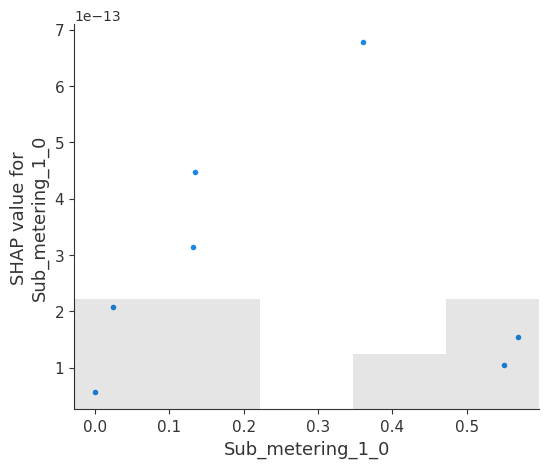

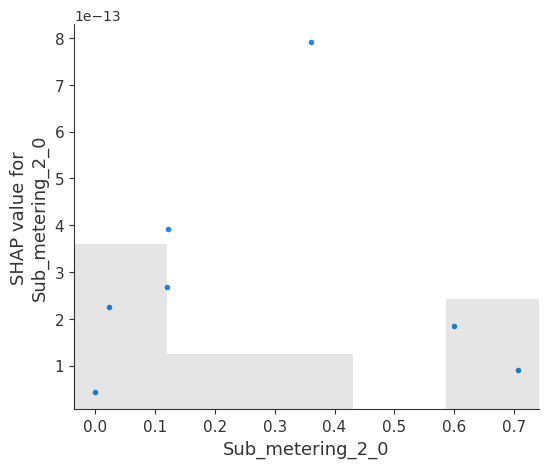

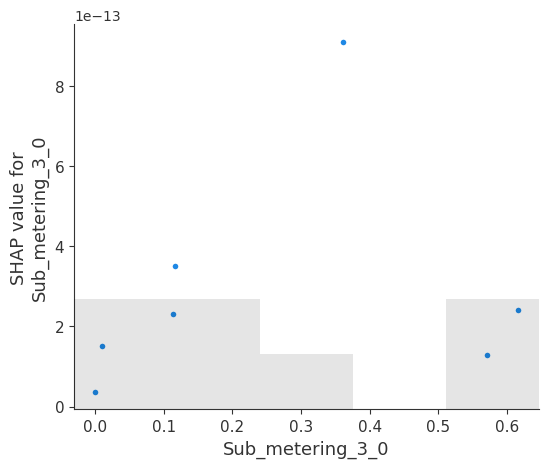

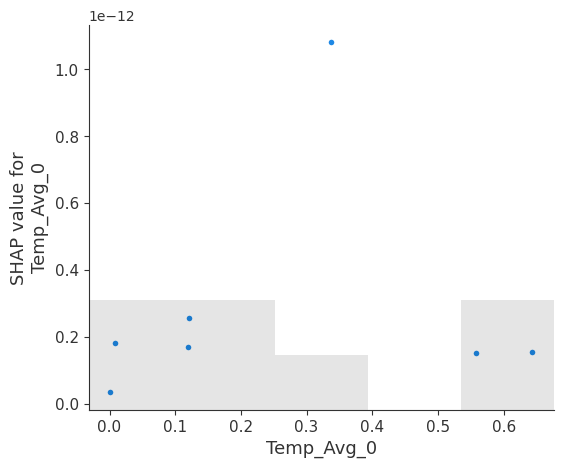

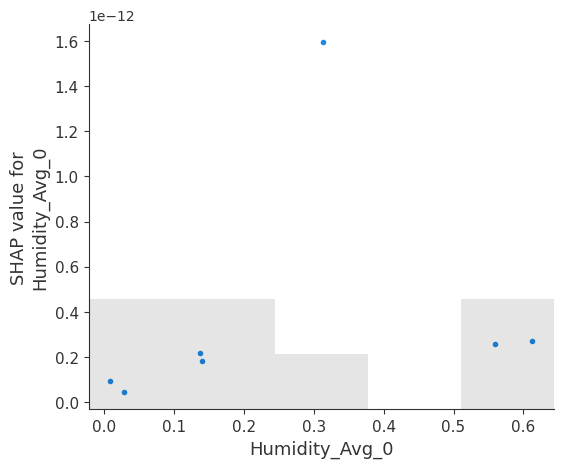

Bar plot


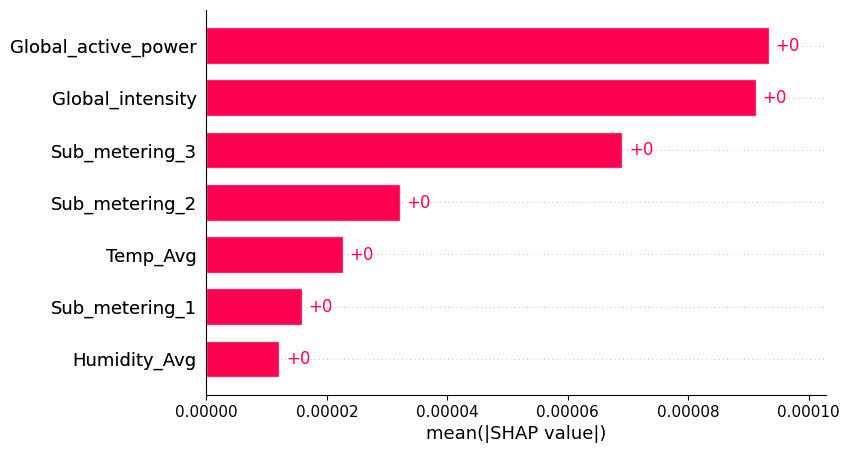

Beeswarm plot


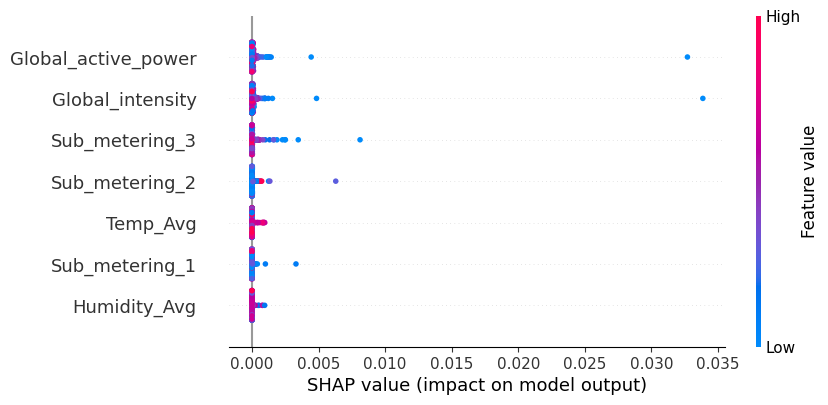

Heatmap plot


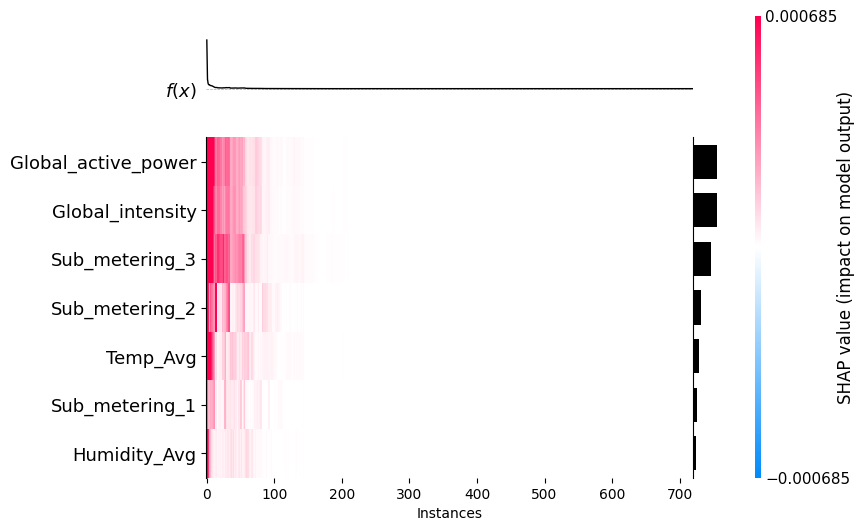

Partial Dependence Plot (feature: Global_active_power, target output index)


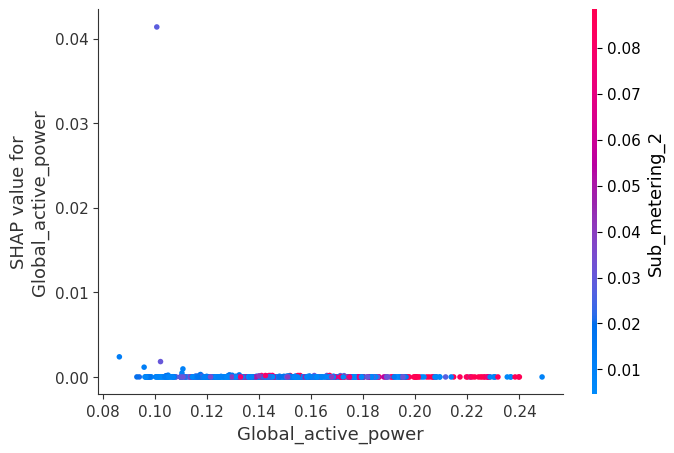

In [10]:
explainer.visualize_all_multiple_samples(shap_values, 
                                         sampled_eval_sequences, 
                                         target_f_idx1=0,
                                         target_f_idx2=1,
                                         target_idx=0)

### Correlation analysis between two features for one sample

1. plot_summary
   - SHAP 값을 요약해서 보여주는 그래프로, 각 피처가 모델의 예측에 얼마나 기여했는지 시각화
   - 전체 피처의 기여도를 분석
   - 해석
       - X축: SHAP 값(피처의 중요도). 값이 클수록 해당 피처가 예측에 큰 영향을 미침
       - Y축: 피처 이름. SHAP 값의 크기에 따라 피처가 순서대로 나열 (상단에 있는 피처일수록 모델 예측에 더 중요한 피처)
       - 색상: 각 피처 값이 높을 때(빨강)와 낮을 때(파랑) SHAP 값의 분포를 보여줌.
       - 점의 분포: 각 점은 하나의 샘플에 해당하며, SHAP 값의 분포가 넓을수록 그 피처가 모델 예측에 미치는 영향이 다양한 경우
2. plot_dependence
   - 선택한 특정 피처와 다른 피처(선택적)의 SHAP 값 간의 관계를 시각화
   - 즉, 피처 간의 상호작용을 분석
   - 해석
       - X축: 특정 피처의 값.
       - Y축: 해당 피처의 SHAP 값(피처가 모델 예측에 기여한 정도).
       - 색상: 상호작용 피처의 값. 두 피처 간의 상호작용이 있을 경우 색상의 변화를 통해 상호작용 효과를 확인할 수 있음. (예를 들어, X축에 있는 피처 값이 증가할 때, 해당 피처가 모델 예측에 기여하는 정도가 어떻게 변하는지 볼 수 있으며, 상호작용 피처가 존재하는 경우, 상호작용 피처 값의 변화에 따라 SHAP 값이 어떻게 변하는지를 색상으로 시각화함)
3. SHAP Value Correlation Plot
   - 모든 피처의 SHAP 값 간의 상관관계를 시각화하는 그래프
   - 해석:
       - 행렬의 각 셀: 두 피처 간의 SHAP 값 상관관계를 나타냄.
       - 값이 1에 가까울수록 두 피처의 SHAP 값이 비슷한 방향으로 모델 예측에 기여하고 있음을 의미.
       - 값이 -1에 가까울수록 두 피처의 SHAP 값이 상반된 방식으로 모델 예측에 기여함을 나타냄.
       - 색상: 상관계수에 따라 색상이 변하며, 상관계수가 클수록 강한 상관관계를 의미(빨강은 양의 상관관계, 파랑은 음의 상관관계).

In [10]:
target_feature_1 = dataset.selected_features[0]
target_feature_2 = dataset.selected_features[4]

print('target_feature_1: ', target_feature_1)
print('target_feature_2: ', target_feature_2)

num_samples = 1  # 여러 샘플을 사용하여 일반화된 분석 시도
shap_values, sampled_eval_sequences = explainer.explain_DeepExplainer(eval_sequences, num_samples=num_samples)

target_feature_1:  Global_active_power
target_feature_2:  Sub_metering_3


/archive/library/anaconda3/envs/xai_311/lib/python3.11/site-packages/shap/explainers/_deep/deep_pytorch.py:243: UserWarning: unrecognized nn.Module: LSTM
  warnings.warn(f'unrecognized nn.Module: {module_type}')


Dependence plot for Global_active_power


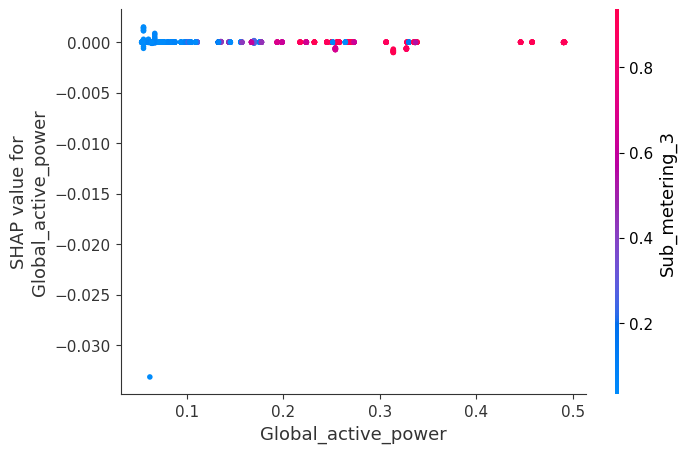

SHAP Value Correlation Plot


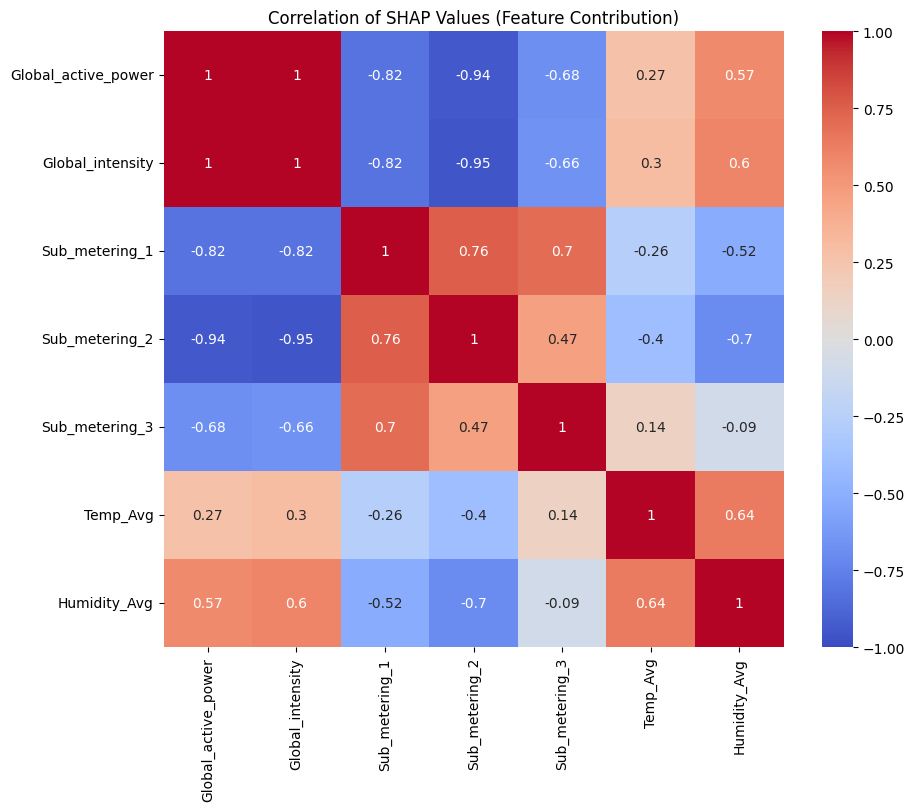

In [11]:
explainer.visualize_correlation(shap_values[0], sampled_eval_sequences[0], 
                                target_feature_1, target_feature_2)

### Correlation analysis for multiple samples

In [14]:
num_samples = 100  # 여러 샘플을 사용하여 일반화된 분석 시도
shap_values, sampled_eval_sequences = explainer.explain_DeepExplainer(eval_sequences, num_samples=num_samples)

/archive/library/anaconda3/envs/xai_311/lib/python3.11/site-packages/shap/explainers/_deep/deep_pytorch.py:243: UserWarning: unrecognized nn.Module: LSTM
  warnings.warn(f'unrecognized nn.Module: {module_type}')


shap_values_mean shape: (720, 7)


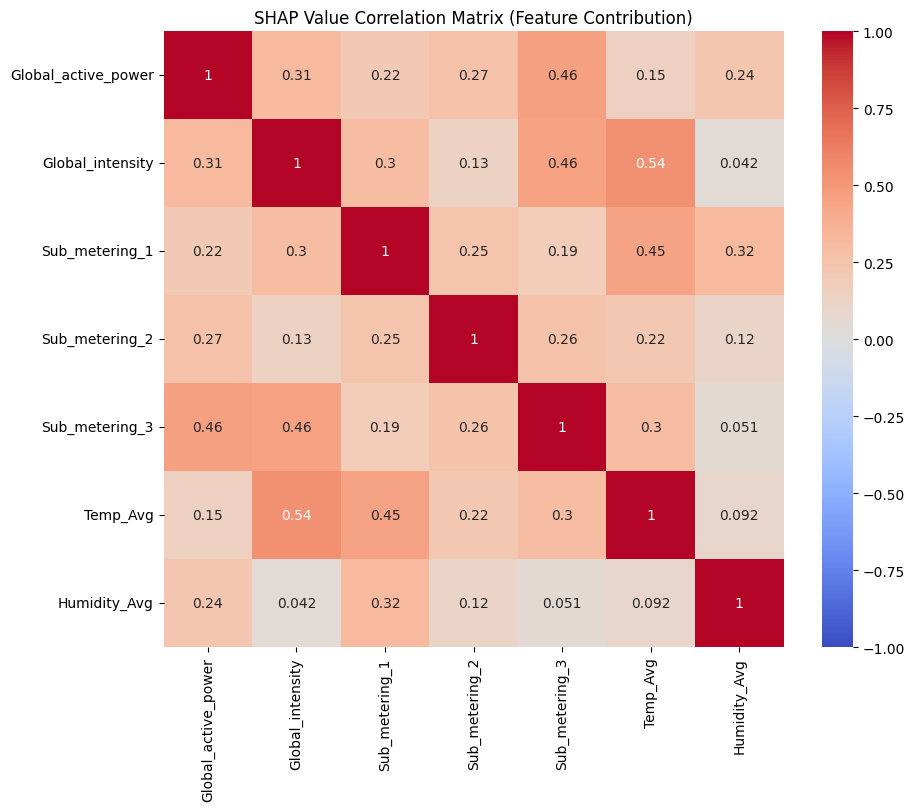

In [15]:
explainer.visualize_correlation_multiple_samples(shap_values, sampled_eval_sequences)

### Attention

In [ ]:
explainer_type = 'Attention' 

if explainer_type == 'LIME':
    explainer = LimeExplainer(model, device, eval_sequences, 
                              sequence_length=60, input_size=input_size, 
                              selected_features=dataset.selected_features)
elif explainer_type == 'SHAP':
    explainer = ShapExplainer(model, eval_sequences, sequence_length, 
                              input_size, dataset.selected_features, device)

elif explainer_type == 'Attention':
    explainer = AttentionExplainer(model_attention, device, eval_sequences, 
                                   sequence_length=60, input_size=input_size, 
                                   selected_features=dataset.selected_features)
    
elif explainer_type == 'GRAD_CAM':
    explainer = GradCAMExplainer(model, device)
    
else:
    raise ValueError(f"Explainer type '{explainer_type}' is not recognized.")

In [ ]:
print(eval_sequences[0].shape)

In [ ]:
random_data_point = eval_sequences[np.random.choice(len(eval_sequences))]

top_n = 20

explainer.visualize_attention(random_data_point, n=top_n)

explainer.analyze_attention_distribution(num_samples=500)

explainer.visualize_attention_heatmap(random_data_point)

explainer.visualize_cumulative_attention(random_data_point, num_points=top_n)

- 추가 데이터 -> LSTM 보고, 지금처럼 결과 비슷하면(마지막 부분 가중치 높으면) 모델 구조를 바꿔보는걸로 (CNN+LSTM 기반)
- 

### Grad-CAM 

- 입력에 대한 기여도 (하나의 time step에서 featureㅂ별 기여도는 동일)

In [16]:
explainer_type = 'GRAD_CAM' 

if explainer_type == 'LIME':
    explainer = LimeExplainer(model, device, train_sequences, 
                              sequence_length=60, input_size=input_size, 
                              selected_features=dataset.selected_features)
    
elif explainer_type == 'SHAP':
    explainer = ShapExplainer(model, train_sequences, sequence_length, 
                              input_size, dataset.selected_features, device)

elif explainer_type == 'GRAD_CAM':
    explainer = GradCAMExplainer(model, device)
    
else:
    raise ValueError(f"Explainer type '{explainer_type}' is not recognized.")

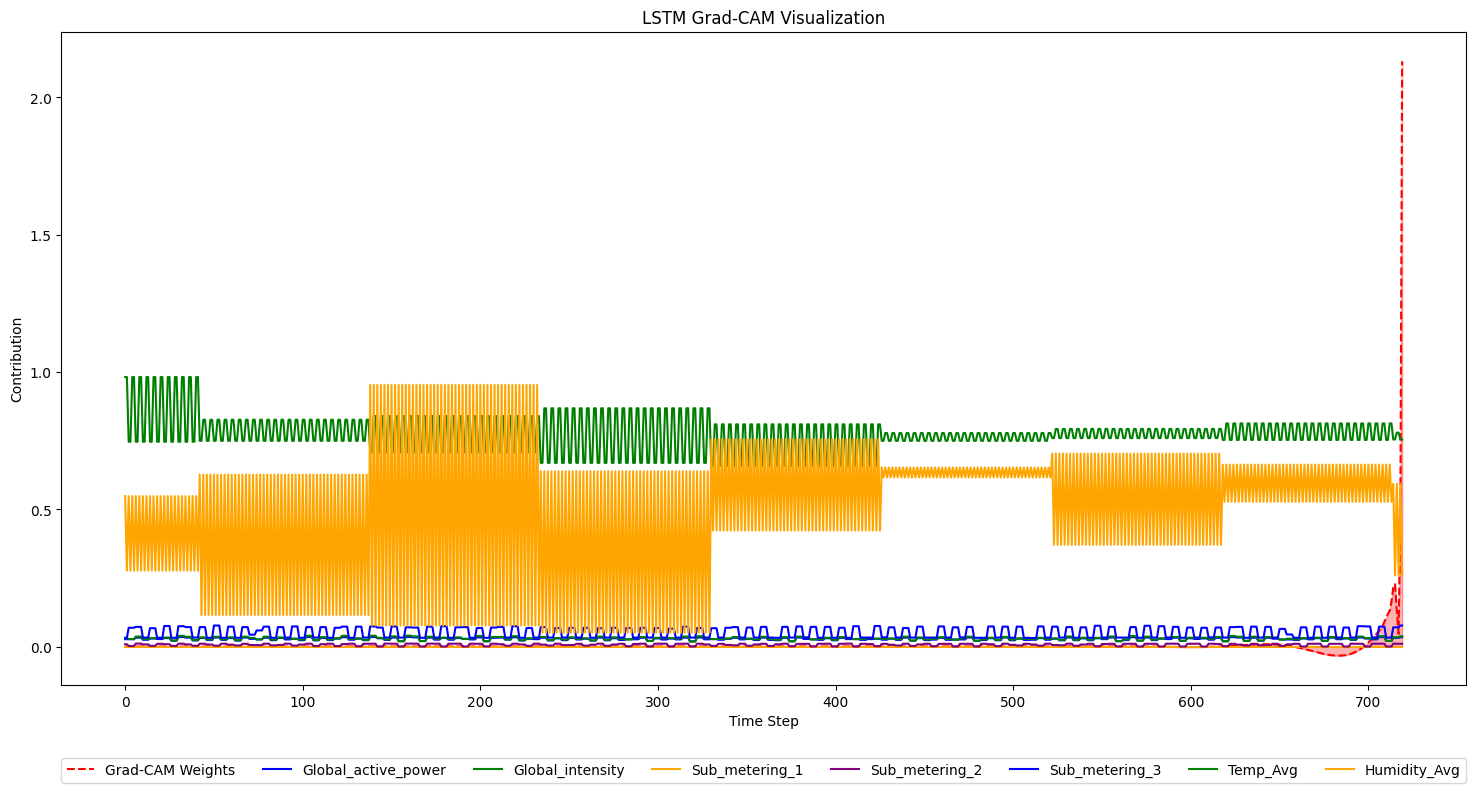

In [17]:
# 사용 예시
data_point = eval_sequences[np.random.choice(len(eval_sequences))]

grad_cam_weights = explainer.compute_grad_cam(data_point)
explainer.visualize_grad_cam(grad_cam_weights, data_point, dataset.selected_features)

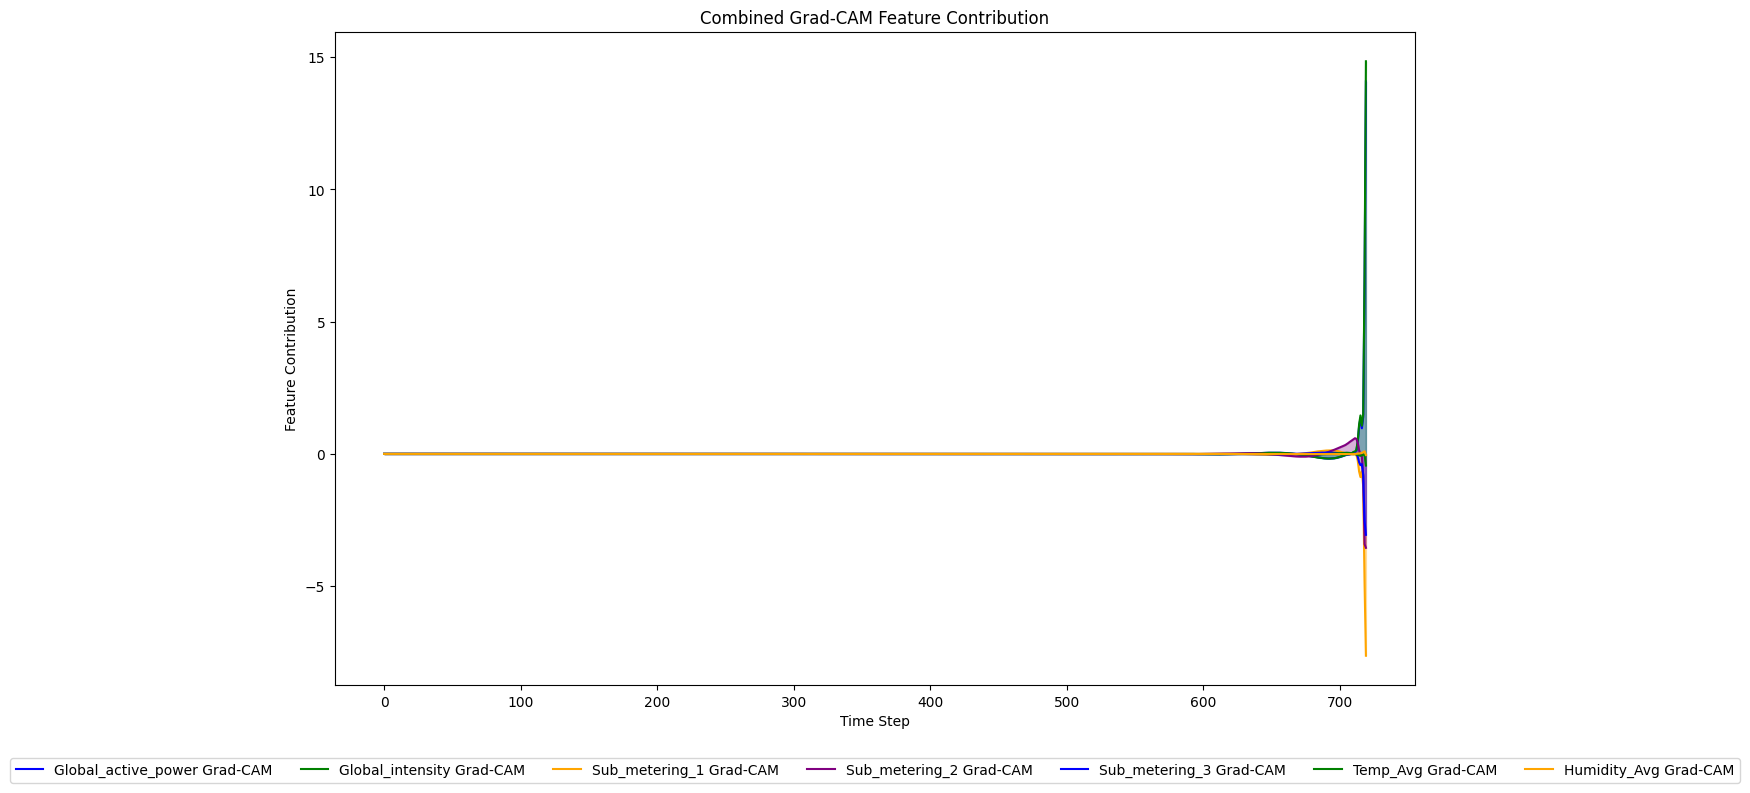

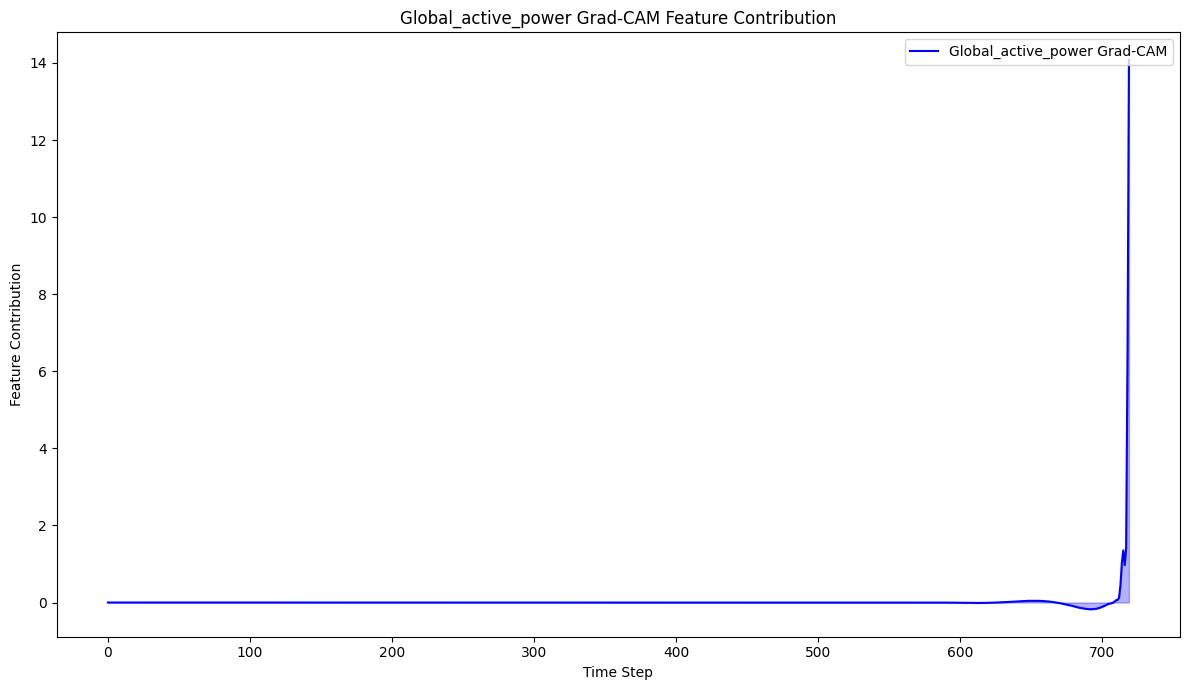

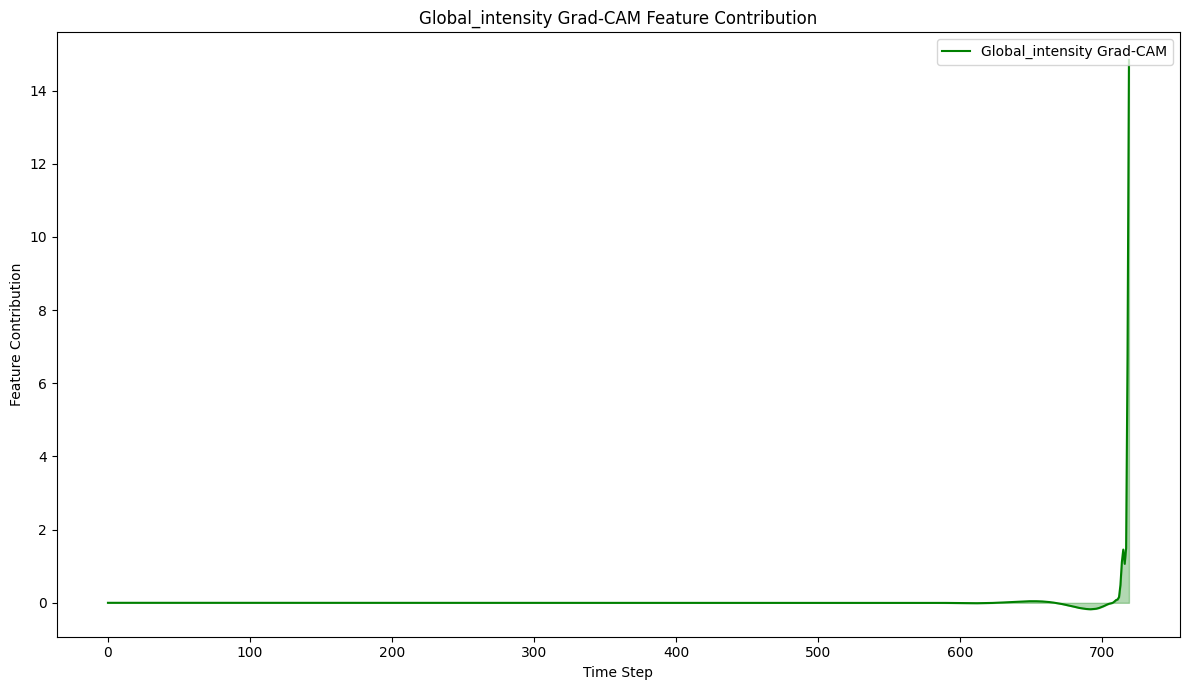

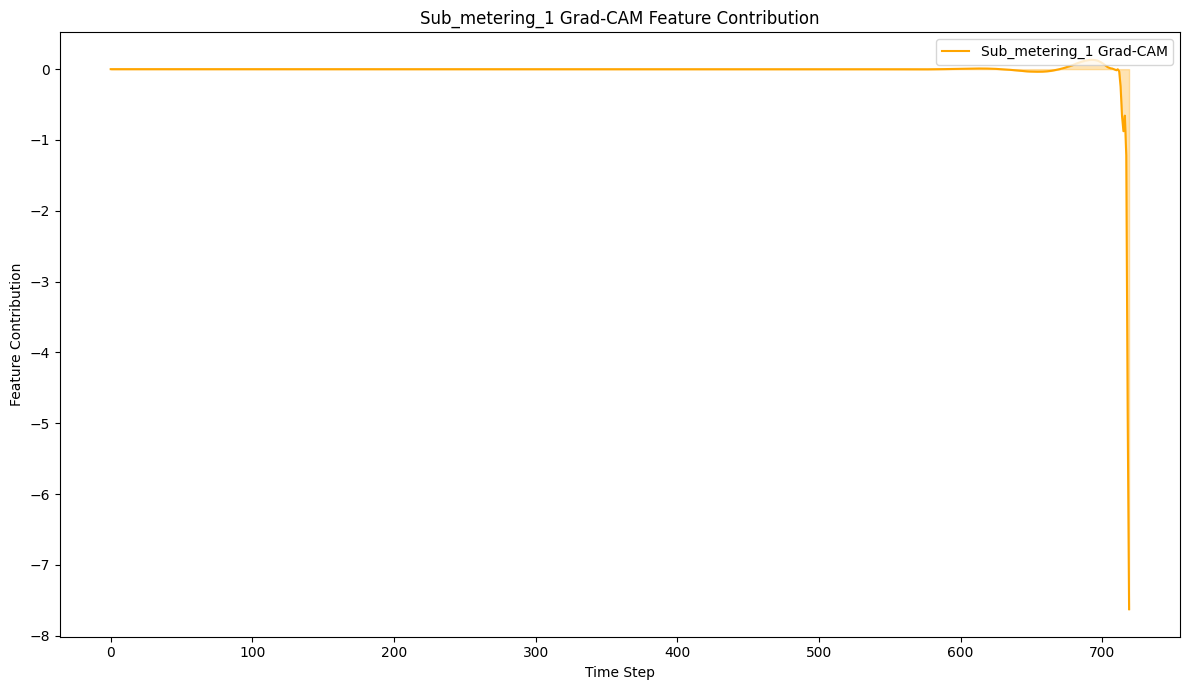

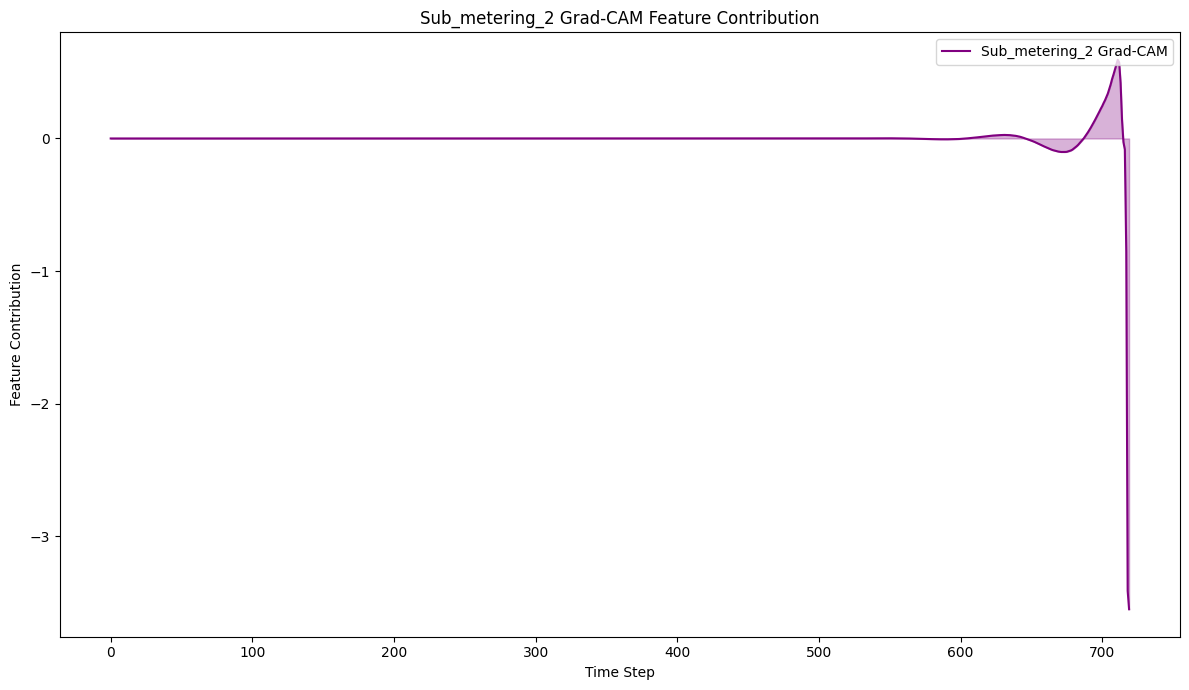

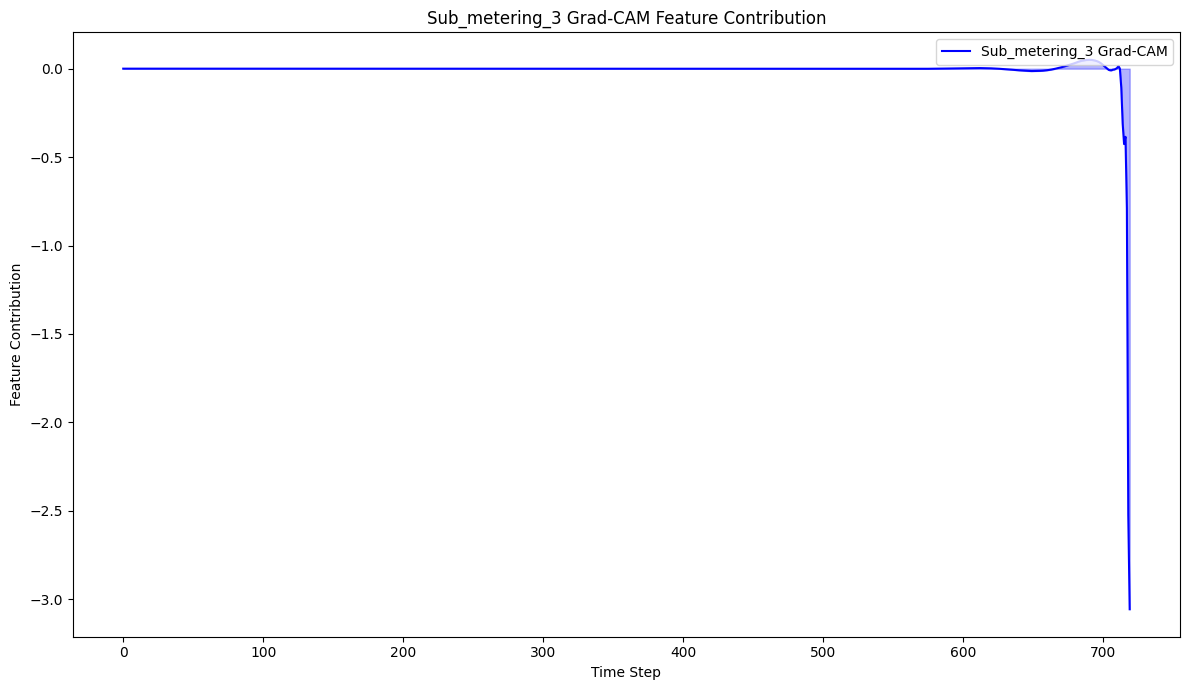

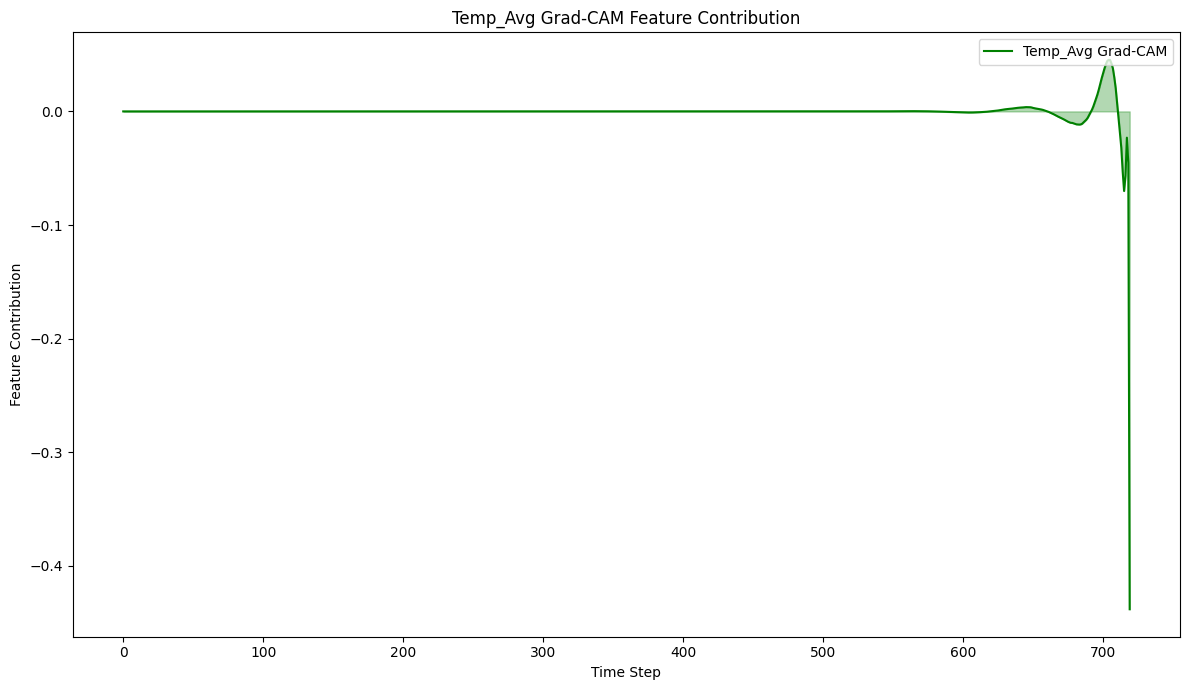

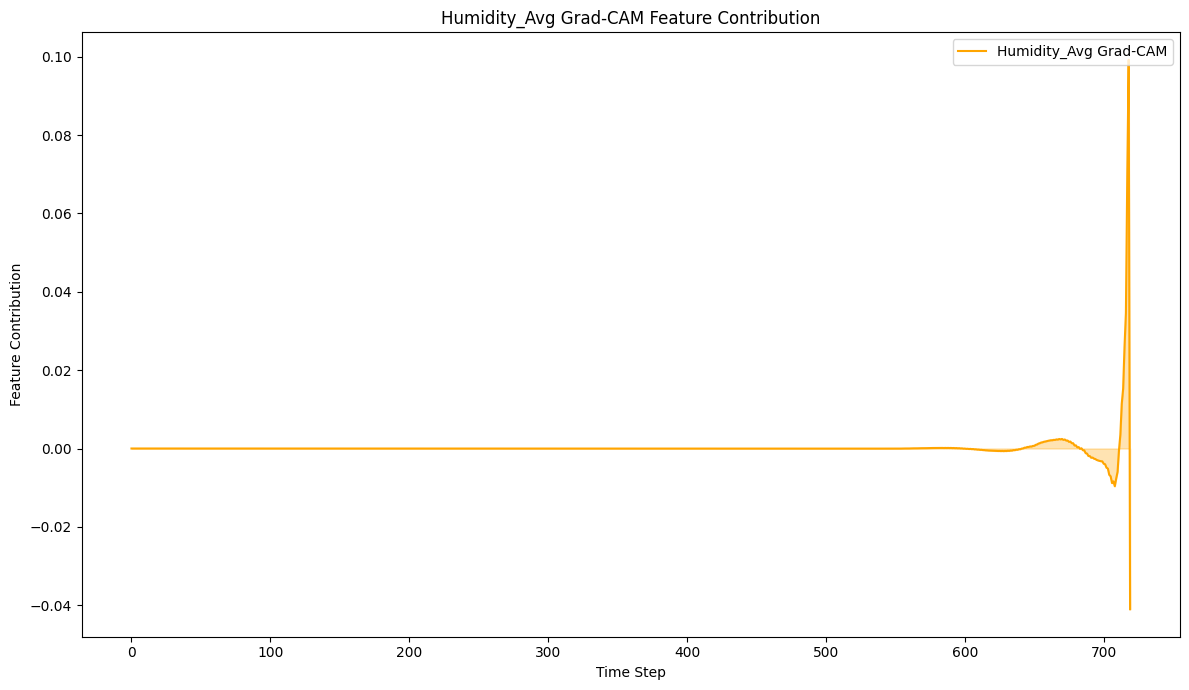

In [18]:
grad_cam_weights_per_feature = explainer.compute_grad_cam_per_feature(data_point)
explainer.visualize_grad_cam_per_feature(grad_cam_weights_per_feature, data_point, dataset.selected_features)

### LRP (개발중)

explainer_type = 'LRP' 

if explainer_type == 'LIME':
    explainer = LimeExplainer(model, device, train_sequences, 
                              sequence_length=60, input_size=input_size, 
                              selected_features=dataset.selected_features)
elif explainer_type == 'SHAP':
    explainer = ShapExplainer(model, train_sequences, sequence_length, 
                              input_size, dataset.selected_features, device)

elif explainer_type == 'Attention':
    explainer = AttentionExplainer(model_attention, device, eval_sequences, 
                                   sequence_length=60, input_size=input_size, 
                                   selected_features=dataset.selected_features)
    
elif explainer_type == 'GRAD_CAM':
    explainer = GradCAMExplainer(model, device)

elif explainer_type == 'LRP':
    explainer = LRPExplainer(model, device, eval_sequences, sequence_length, 
                             input_size, dataset.selected_features)


else:
    raise ValueError(f"Explainer type '{explainer_type}' is not recognized.")

In [ ]:
data_point = eval_sequences[np.random.choice(len(eval_sequences))]
relevance_values = explainer.explain(data_point)

# LRP 결과 시각화
explainer.visualize_lrp(relevance_values, data_point)

## 앞으로 할일
- 코드 정리
- 모델 구조 추가 (CNN 기반)
- 데이터 수정(15분 단위) or 다른 데이터셋 활용
- 각 설명모듈의 시각화 결과에 대한 전문화된 설명 생성(템플릿 기반) 
- 다른 Explainer 추가 (LRP, Gradient 기반 등)
- (optional) 데이터 분포 시각화

- 날씨, 온도, 습도, 풍향 정보 등 데이터 활용해서 함께 학습 -> 기존 데이터는 하루치로 합산하여 함께 사용 (일 단위로)
- Global active power랑 Sub_metering_1
/Sub_metering_2/ Sub_metering_3 사이의 상관관계 비교 필요 -> 온도/풍향 데이터랑도 관련 있음
- 기존 <-> 추가 데이터 한것을 비교


1018
- 랜덤 데이터에서 시간을 보여주면 좋겠음. 데이터 원데이터 보여주기 (normalize 전)
- 데이터를 지금처럼 말고, 요일별로 묶어서 하거나, -> 한시간 데이터로 바꾸고, Global_reactive_power / Voltage 빼고 -> 온도/습도/강수량 넣기. datetime의 요일, 시간 feature로 추가 -> 상관관계 확인

- 6개월/1년치를 보고 -> 하루(24개) + 일주일치 예측
- XAI를 확인 -> 모델 트랜드만 예측

- 적합한 XAI 알고리즘